# Energy Consumption by household in the UK


In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')
import joblib

<ipython-input-1-5bcd47c041a9>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [130]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario2.csv',
                             keep_default_na=False)

In [131]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'weekday', 'hour', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'weekend'],
      dtype='object')

In [132]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [133]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [134]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [135]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.127,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,0.231,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054


In [136]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

,year,month,day,weekday,hour,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,2011,11,26,5,23,0.072,13.70,232,11.59,7.18,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,2011,11,27,6,0,0.091,14.13,229,11.98,7.98,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,2011,11,27,6,0,0.054,14.13,229,11.98,7.98,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054
27,2011,11,27,6,1,0.068,13.60,233,12.08,8.28,...,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068
28,2011,11,27,6,1,0.084,13.60,233,12.08,8.28,...,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,2014,1,30,3,2,0.080,4.78,40,4.18,2.69,...,0.341,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080
39548,2014,2,4,1,5,0.067,13.81,225,5.63,2.26,...,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067
39549,2014,2,9,6,17,0.406,12.15,231,6.72,-1.73,...,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406
39550,2014,2,15,5,7,0.145,12.39,228,8.59,2.30,...,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406,0.145


In [137]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[2.01100000e+03, 1.10000000e+01, 2.60000000e+01, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [2.01400000e+03, 2.00000000e+00, 9.00000000e+00, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 1h, are set as the testing set, and the rest is training set

In [138]:
# split into train and test sets
train = reframed[:(len(reframed)-2), :]
test = reframed[(len(reframed)-2):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [139]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [140]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [141]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [142]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [143]:
train_X.shape

(39526, 39)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [102]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [103]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [104]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

ValueError: ignored

A prediction is made on the test set.

In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [ ]:
import matplotlib
import seaborn as sns

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [ ]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario2.joblib')

### support vector regressor (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [ ]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

**Prediction**

In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_SVR.jpeg', dpi = 500)
plt.show()

Although the model picked up on the general trend, it clearly lacks the performance of the MLR.

In [ ]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario2.joblib')

### random forest (RF)

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

**Prediction**

In [ ]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

In [ ]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_RF.jpeg', dpi = 500)
plt.show()

The model is predicting very well, picking up on very fine energy consumption trends

### feedforward neural networks (FFNNs)

Data must be reshaped for the neural networks models to work

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [ ]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [ ]:
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [ ]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [ ]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

In [105]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

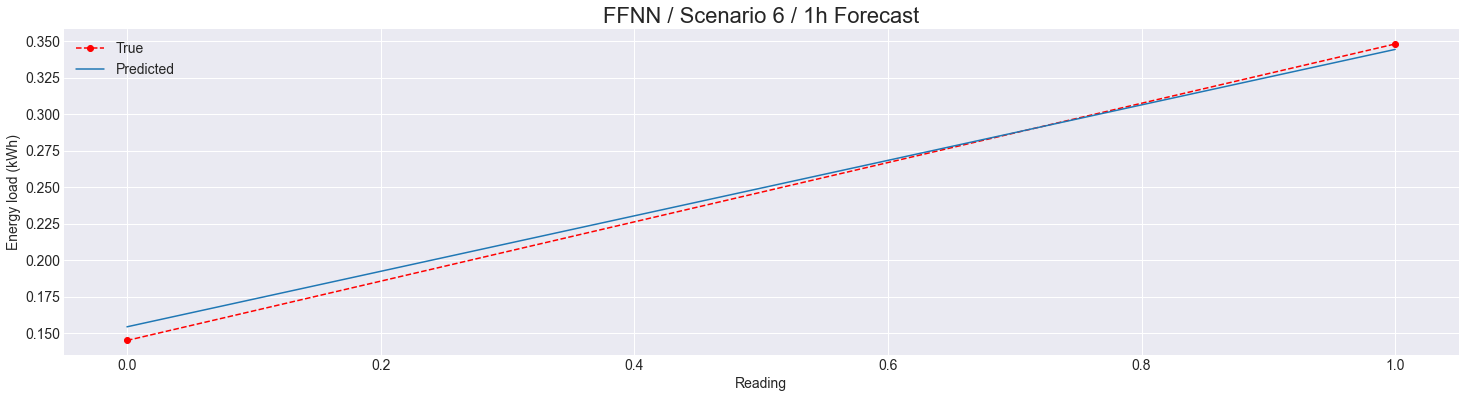

In [106]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [107]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [108]:
from keras.optimizers import Adam

Epoch 1/30
1647/1647 - 2s - loss: 0.0342
Epoch 2/30
1647/1647 - 2s - loss: 9.7729e-04
Epoch 3/30
1647/1647 - 2s - loss: 0.0012
Epoch 4/30
1647/1647 - 2s - loss: 2.6780e-04
Epoch 5/30
1647/1647 - 2s - loss: 3.5187e-04
Epoch 6/30
1647/1647 - 2s - loss: 2.6373e-04
Epoch 7/30
1647/1647 - 2s - loss: 2.7735e-04
Epoch 8/30
1647/1647 - 2s - loss: 3.3682e-04
Epoch 9/30
1647/1647 - 2s - loss: 2.1739e-04
Epoch 10/30
1647/1647 - 2s - loss: 3.1744e-04
Epoch 11/30
1647/1647 - 2s - loss: 1.3305e-04
Epoch 12/30
1647/1647 - 2s - loss: 2.8727e-04
Epoch 13/30
1647/1647 - 2s - loss: 3.3792e-04
Epoch 14/30
1647/1647 - 2s - loss: 1.1972e-04
Epoch 15/30
1647/1647 - 2s - loss: 3.8344e-04
Epoch 16/30
1647/1647 - 2s - loss: 1.1830e-04
Epoch 17/30
1647/1647 - 2s - loss: 3.5019e-04
Epoch 18/30
1647/1647 - 2s - loss: 1.4558e-04
Epoch 19/30
1647/1647 - 2s - loss: 1.6152e-04
Epoch 20/30
1647/1647 - 2s - loss: 2.6742e-04
Epoch 21/30
1647/1647 - 3s - loss: 1.4793e-04
Epoch 22/30
1647/1647 - 3s - loss: 2.0647e-04
Epoch

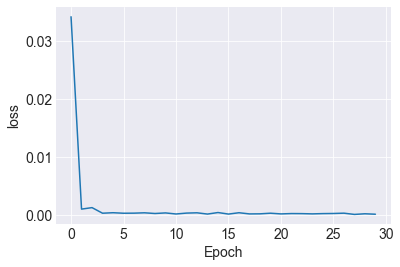

Training time: 67.324 s


In [109]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [110]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [111]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.989884443369406
Mse:  0.000106464502950
Rmse: 0.010318163739259
Mae:  0.010260365903378
Mape:  4.553289999512717
Training time: 67.324 s


In [112]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

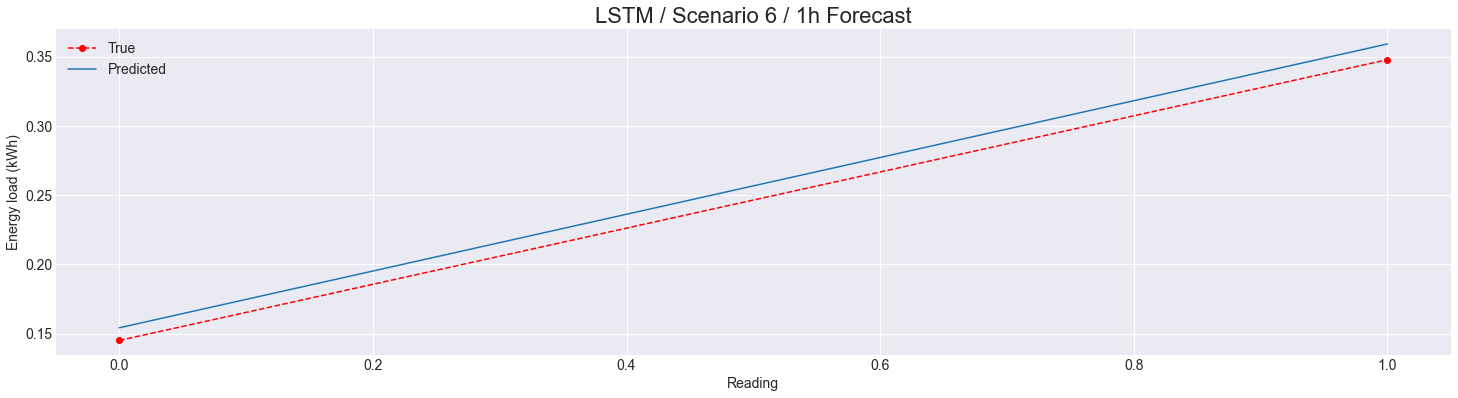

In [113]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [114]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1647/1647 - 1s - loss: 0.0207
Epoch 2/30
1647/1647 - 2s - loss: 4.9309e-04
Epoch 3/30
1647/1647 - 1s - loss: 5.8606e-04
Epoch 4/30
1647/1647 - 1s - loss: 0.0010
Epoch 5/30
1647/1647 - 1s - loss: 2.4699e-04
Epoch 6/30
1647/1647 - 1s - loss: 4.5510e-04
Epoch 7/30
1647/1647 - 1s - loss: 6.0281e-04
Epoch 8/30
1647/1647 - 2s - loss: 4.3786e-04
Epoch 9/30
1647/1647 - 2s - loss: 2.3943e-04
Epoch 10/30
1647/1647 - 2s - loss: 3.2952e-04
Epoch 11/30
1647/1647 - 1s - loss: 3.8195e-04
Epoch 12/30
1647/1647 - 1s - loss: 2.7799e-04
Epoch 13/30
1647/1647 - 1s - loss: 2.9835e-04
Epoch 14/30
1647/1647 - 2s - loss: 2.9544e-04
Epoch 15/30
1647/1647 - 1s - loss: 1.3092e-04
Epoch 16/30
1647/1647 - 1s - loss: 1.4642e-04
Epoch 17/30
1647/1647 - 1s - loss: 1.5612e-04
Epoch 18/30
1647/1647 - 1s - loss: 1.6645e-04
Epoch 19/30
1647/1647 - 1s - loss: 1.6506e-04
Epoch 20/30
1647/1647 - 1s - loss: 1.3119e-04
Epoch 21/30
1647/1647 - 1s - loss: 9.7205e-05
Epoch 22/30
1647/1647 - 1s - loss: 2.1112e-04
Epoch

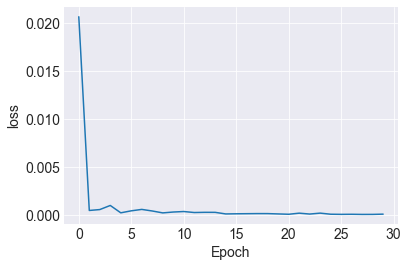

Training time: 43.191 s


In [115]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [116]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario2.h5')

In [117]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario2.h5")
print("Saved model to disk")
 

Saved model to disk


In [118]:
from keras.models import model_from_json


In [119]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario2.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data


Loaded model from disk


**Prediction**

In [120]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [121]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999943791094267
Mse:  0.000000573856518
Rmse: 0.000757533179379
Mae:  0.000602900981903
Mape:  0.202778075802748
Training time: 43.191 s


In [122]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

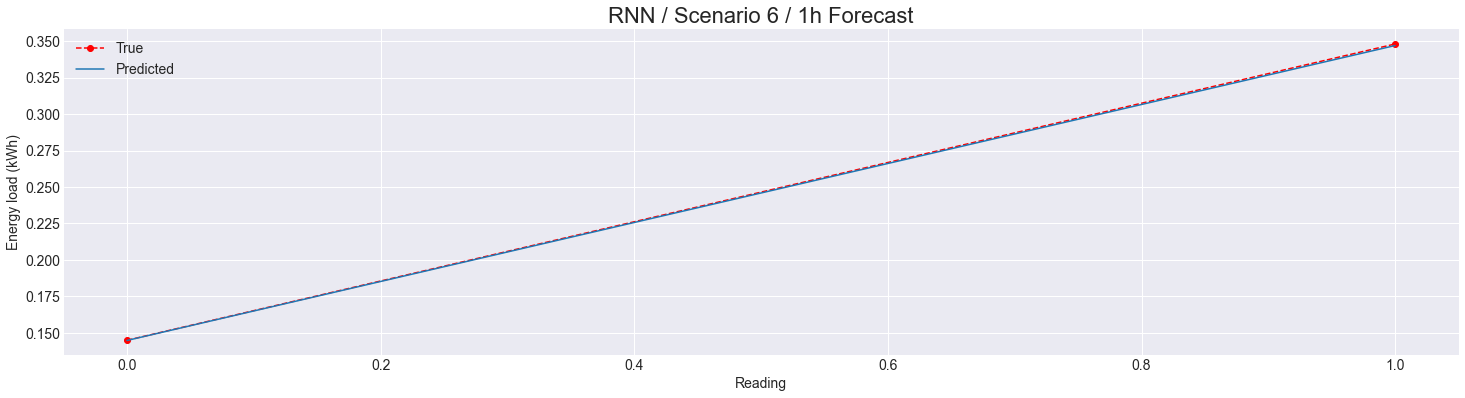

In [123]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

In order to fully leverage the neural network achitecture, an LSTM layer is combined with two dense ones. 

Epoch 1/30
618/618 - 2s - loss: 0.0806
Epoch 2/30
618/618 - 1s - loss: 0.0229
Epoch 3/30
618/618 - 1s - loss: 0.0012
Epoch 4/30
618/618 - 1s - loss: 9.2201e-04
Epoch 5/30
618/618 - 1s - loss: 7.5765e-04
Epoch 6/30
618/618 - 1s - loss: 6.0268e-04
Epoch 7/30
618/618 - 1s - loss: 6.3012e-04
Epoch 8/30
618/618 - 1s - loss: 4.9408e-04
Epoch 9/30
618/618 - 1s - loss: 4.7982e-04
Epoch 10/30
618/618 - 1s - loss: 5.1521e-04
Epoch 11/30
618/618 - 1s - loss: 3.4723e-04
Epoch 12/30
618/618 - 1s - loss: 6.0713e-04
Epoch 13/30
618/618 - 1s - loss: 2.9264e-04
Epoch 14/30
618/618 - 1s - loss: 4.0497e-04
Epoch 15/30
618/618 - 1s - loss: 2.5509e-04
Epoch 16/30
618/618 - 1s - loss: 6.0430e-04
Epoch 17/30
618/618 - 1s - loss: 1.9779e-04
Epoch 18/30
618/618 - 2s - loss: 3.6370e-04
Epoch 19/30
618/618 - 1s - loss: 1.8634e-04
Epoch 20/30
618/618 - 1s - loss: 5.7620e-04
Epoch 21/30
618/618 - 1s - loss: 1.4209e-04
Epoch 22/30
618/618 - 1s - loss: 3.3666e-04
Epoch 23/30
618/618 - 1s - loss: 1.6839e-04
Epoch 24/

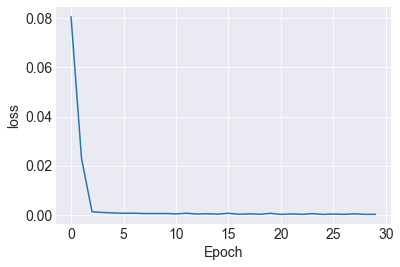

Training time: 41.884 s


In [124]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [125]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario2_1h.h5')

**Prediction**

In [126]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [127]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.992121873723154
Mse:  0.000093392271819
Rmse: 0.009663967705804
Mae:  0.007378973066807
Mape:  5.346238495601773
Training time: 41.884 s


In [128]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

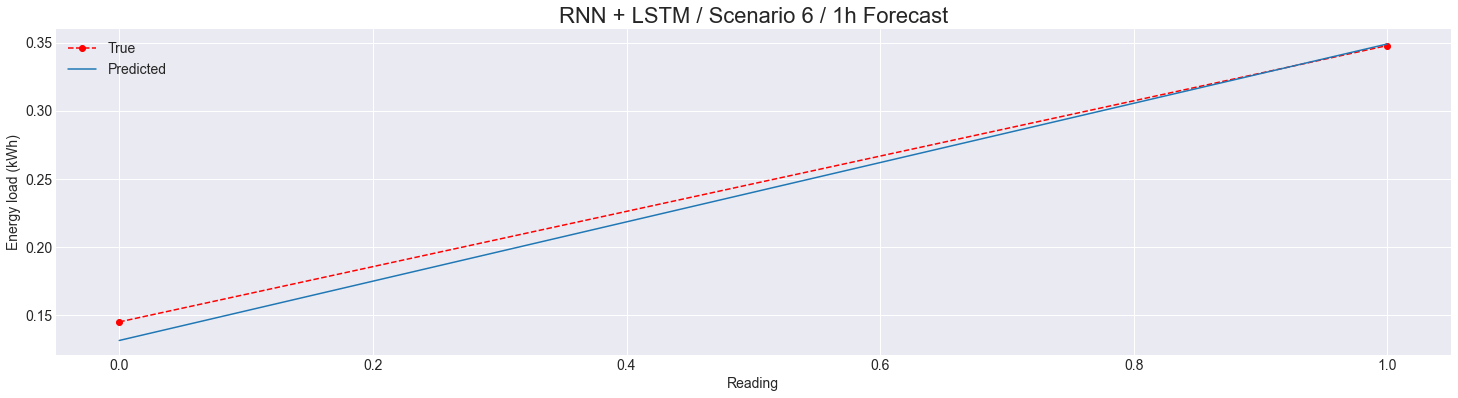

In [129]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 6 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.


## Best model

In [ ]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

,MLR,SVM,RF,FFNNs,LSTM,RNN,Dense+LSTM
R2_scores,1.000000e+00,9.999995e-01,0.966134,0.962961,0.987104,0.999824,0.997516
MSE_scores,5.586043e-17,5.329449e-09,0.000421,0.000364,0.000137,0.000002,0.000028
RMSE_scores,7.473984e-09,7.300307e-05,0.020507,0.019072,0.011687,0.001343,0.005249
MAE_scores,6.766743e-09,5.706913e-05,0.017941,0.018920,0.011601,0.001334,0.003822
MAPE_scores,2.667229e-06,3.701105e-02,6.324701,8.675641,5.085237,0.677456,2.728643
Train_Time,5.086422e-02,2.338834e-01,30.066703,61.453917,64.891855,47.177970,43.346387


In [ ]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario2_1h.csv', index=False)

**Plotting all models together.**

In [73]:
prev_day = train_y[-48:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [74]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [75]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario2.csv').time)[-96:]

In [ ]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [ ]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [ ]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [ ]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [ ]:
df_for_plotting.columns

In [ ]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 6')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

In [ ]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Models predictions vs True values / Scenario 6')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

In [ ]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 6')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/1_allHouseholds/S6_1h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [77]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [78]:
houses_data

,LCLid,tstp,energy(kWh/hh)
0,2,2012-10-12 00:30:00,0.000
1,2,2012-10-12 01:00:00,0.000
2,2,2012-10-12 01:30:00,0.000
3,2,2012-10-12 02:00:00,0.000
4,2,2012-10-12 02:30:00,0.000
...,...,...,...
8092712,5124,2014-02-27 22:00:00,0.673
8092713,5124,2014-02-27 22:30:00,0.590
8092714,5124,2014-02-27 23:00:00,0.552
8092715,5124,2014-02-27 23:30:00,0.519


In [79]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [80]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [81]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [82]:
weather_energy = weather_energy.drop(columns = ['holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped'])

In [83]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [84]:
updated_houses

,LCLid,time,energy(kWh/hh)_x,year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,weekend
0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
1,246,2012-10-12 00:30:00,0.975,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
2,1074,2012-10-12 00:30:00,1.438,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
3,3281,2012-10-12 00:30:00,0.078,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
4,3305,2012-10-12 00:30:00,0.101,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,183,2011-12-03 06:30:00,0.109,2011,12,3,6,5,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95,1
8086037,183,2011-12-03 07:00:00,0.030,2011,12,3,7,5,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,1
8086038,183,2011-12-03 07:30:00,0.082,2011,12,3,7,5,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,1
8086039,183,2011-12-03 08:00:00,0.030,2011,12,3,8,5,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88,1


In [85]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'weekend'],
      dtype='object')

In [86]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'weekend']

In [87]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S2.csv')

In [88]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S2.csv')

In [89]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086041 entries, 0 to 8086040
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   year                 int64  
 5   month                int64  
 6   day                  int64  
 7   hour                 int64  
 8   weekday              int64  
 9   energy(kWh/hh)_y     float64
 10  visibility           float64
 11  windBearing          int64  
 12  temperature          float64
 13  dewPoint             float64
 14  pressure             float64
 15  apparentTemperature  float64
 16  windSpeed            float64
 17  humidity             float64
 18  weekend              int64  
dtypes: float64(9), int64(9), object(1)
memory usage: 1.1+ GB


In [90]:
updated_houses.columns

Index(['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'year', 'month', 'day',
       'hour', 'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'weekend'],
      dtype='object')

In [91]:
updated_houses[updated_houses.LCLid==2]

,Unnamed: 0,LCLid,time,energy(kWh/hh),year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,weekend
0,0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0
258,258,2,2012-10-12 01:00:00,0.000,2012,10,12,1,4,0.094,13.50,250,13.09,11.37,1000.10,13.09,6.77,0.89,0
516,516,2,2012-10-12 01:30:00,0.000,2012,10,12,1,4,0.125,13.50,250,13.09,11.37,1000.10,13.09,6.77,0.89,0
774,774,2,2012-10-12 02:00:00,0.000,2012,10,12,2,4,0.081,13.50,252,12.54,10.27,1000.51,12.54,6.46,0.86,0
1032,1032,2,2012-10-12 02:30:00,0.000,2012,10,12,2,4,0.132,13.50,252,12.54,10.27,1000.51,12.54,6.46,0.86,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499697,6499697,2,2014-02-27 22:00:00,0.416,2014,2,27,22,3,0.171,14.00,216,4.10,1.64,1005.67,1.41,3.02,0.84,0
6499954,6499954,2,2014-02-27 22:30:00,1.350,2014,2,27,22,3,0.504,14.00,216,4.10,1.64,1005.67,1.41,3.02,0.84,0
6500211,6500211,2,2014-02-27 23:00:00,1.247,2014,2,27,23,3,0.176,14.03,200,3.93,1.61,1004.62,1.42,2.75,0.85,0
6500468,6500468,2,2014-02-27 23:30:00,1.218,2014,2,27,23,3,0.136,14.03,200,3.93,1.61,1004.62,1.42,2.75,0.85,0


Function to check another household:

In [92]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [93]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [94]:
from keras.models import Sequential, load_model
from joblib import dump, load


In [95]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28',
                      'HH_29']

In [96]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))




  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 6)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/2_singleHouseholdLevel/best_NN_model/S6_1h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


In [97]:
from keras.optimizers import Adam

Mse:  451.903953180797430
Rmse: 21.258032674280972
Mae:  21.258032117038965
Mape:  99.417747336191795


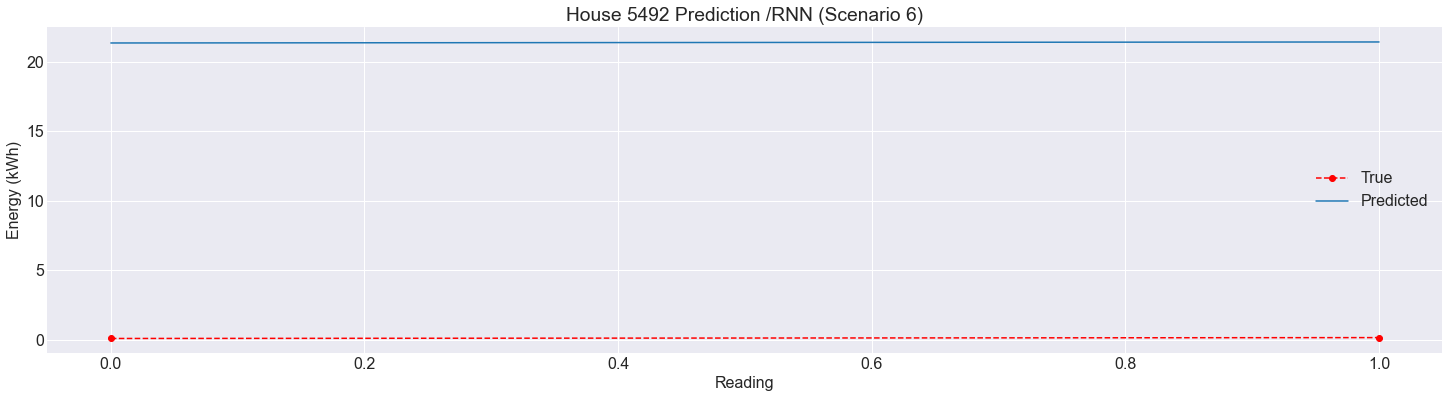

Mse:  392.068763843206966
Rmse: 19.800726346354242
Mae:  19.792130734771490
Mape:  100.789923599810024


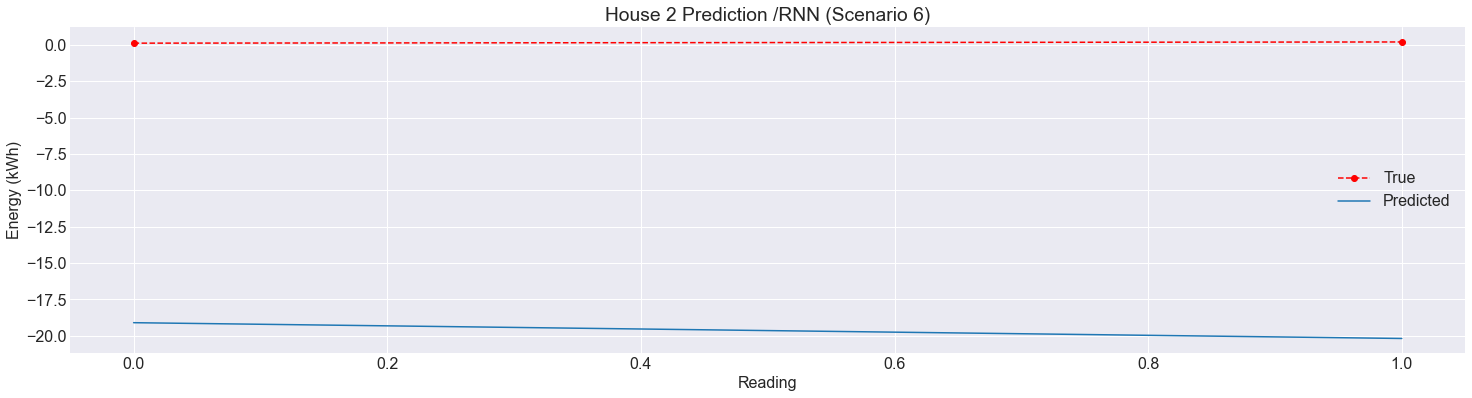

Mse:  121834.010154389936361
Rmse: 349.047289280965401
Mae:  349.047278210520744
Mape:  99.905975167989240


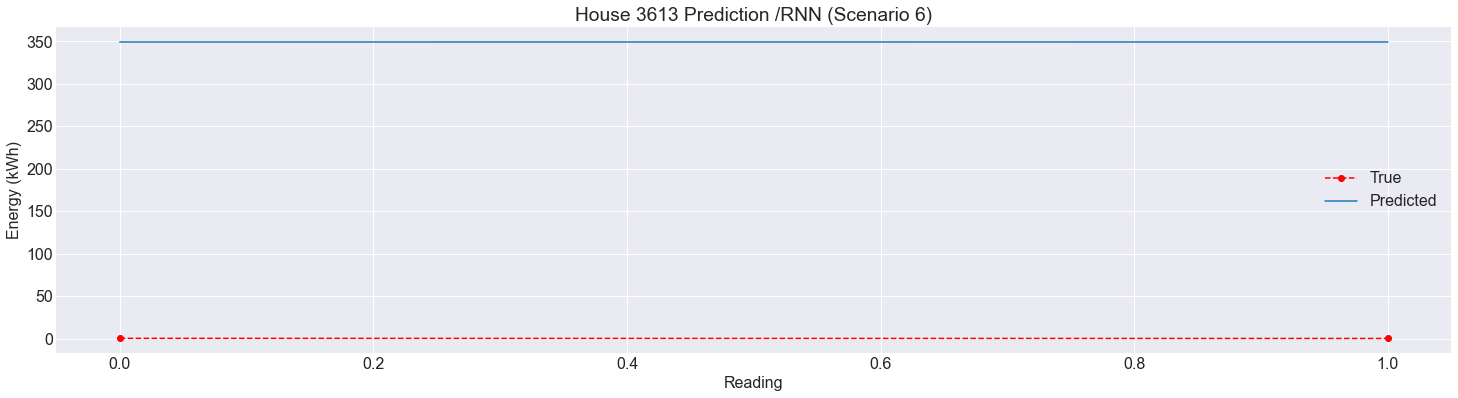

Mse:  3530.418494503464899
Rmse: 59.417324868286229
Mae:  59.417214930057526
Mape:  100.262395438484191


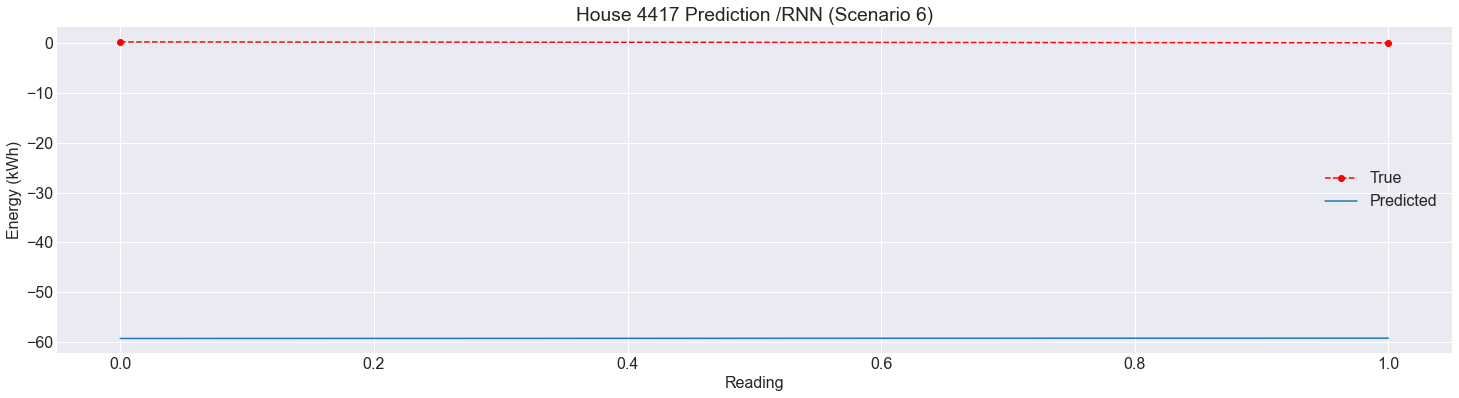

Mse:  22020.891761822429544
Rmse: 148.394379144974465
Mae:  148.394377930089831
Mape:  99.971031555331464


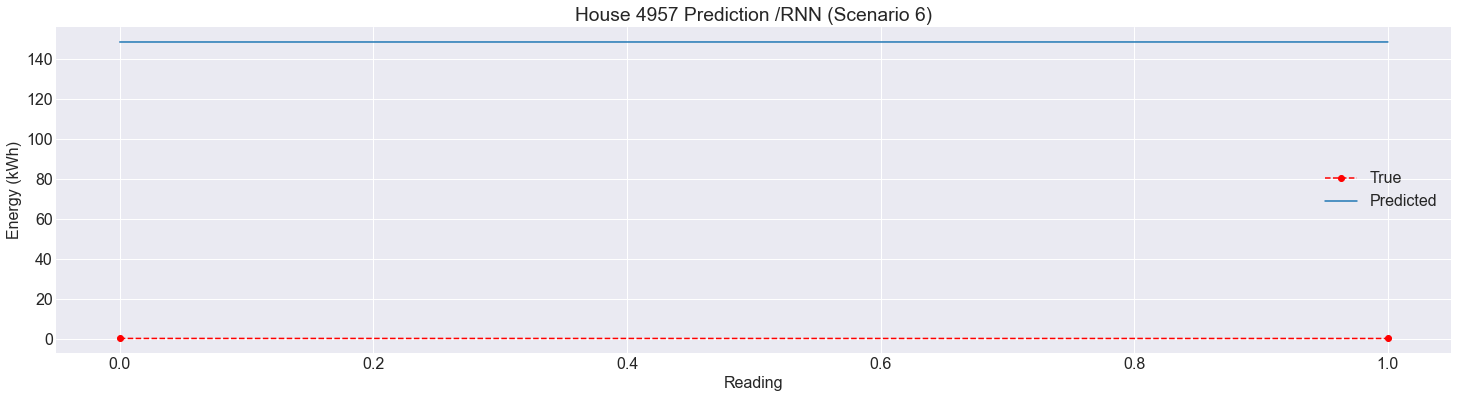

Mse:  8421.474589344463311
Rmse: 91.768592608497940
Mae:  91.768532443791628
Mape:  99.887886874451155


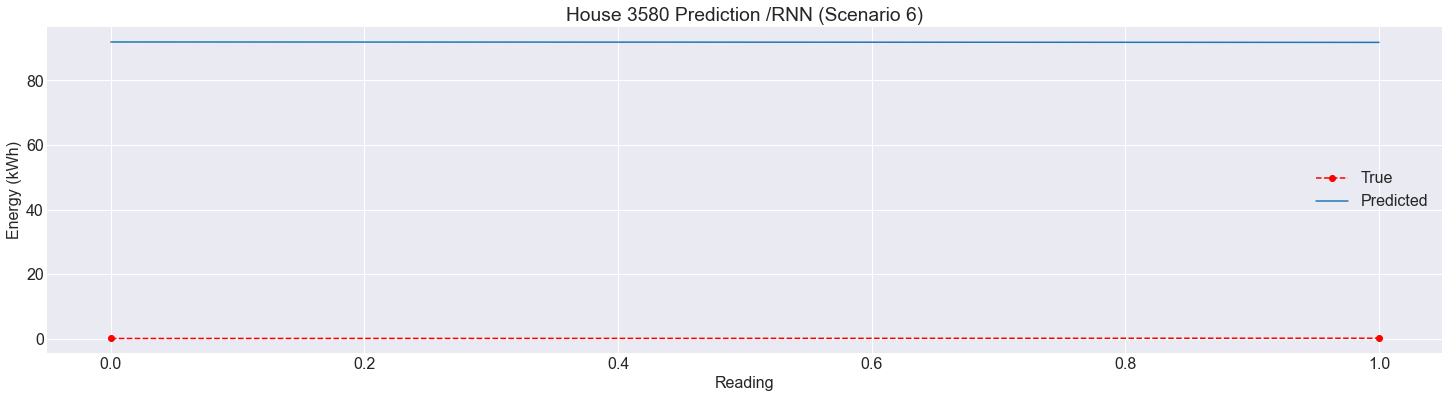

Mse:  147904.168455157720018
Rmse: 384.583109945246690
Mae:  384.583104614168406
Mape:  99.971795589166959


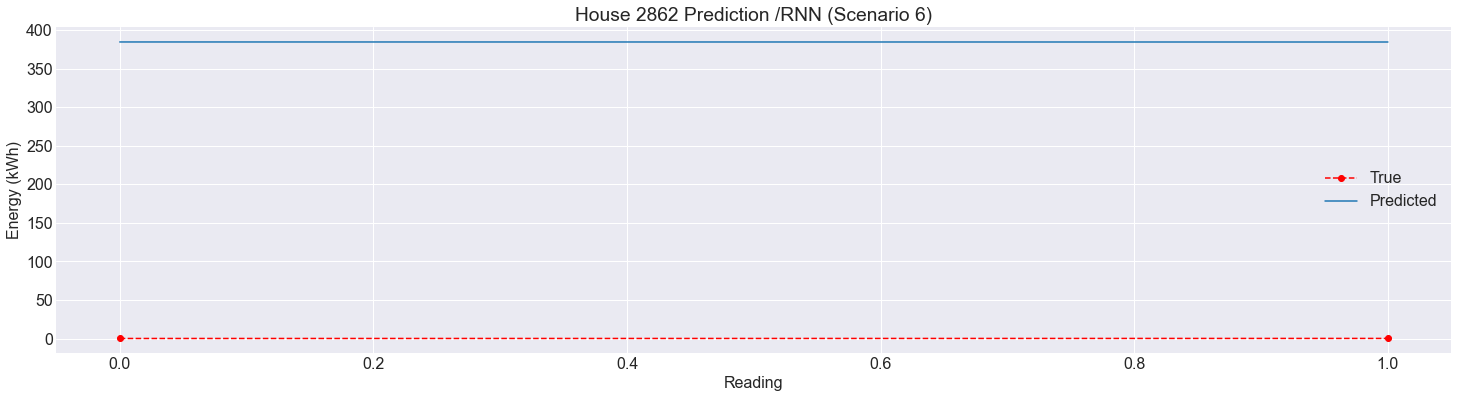

Mse:  35669.539837407573941
Rmse: 188.863812937808632
Mae:  188.863811522722244
Mape:  100.036812549453941


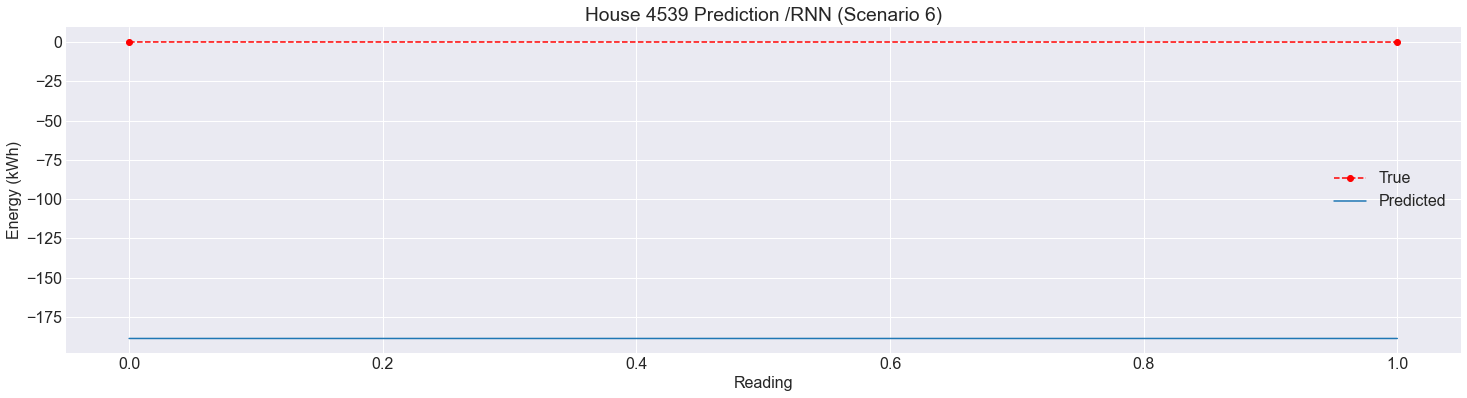

Mse:  79112.441602206585230
Rmse: 281.269339961195556
Mae:  281.269245608709753
Mape:  99.926281653798299


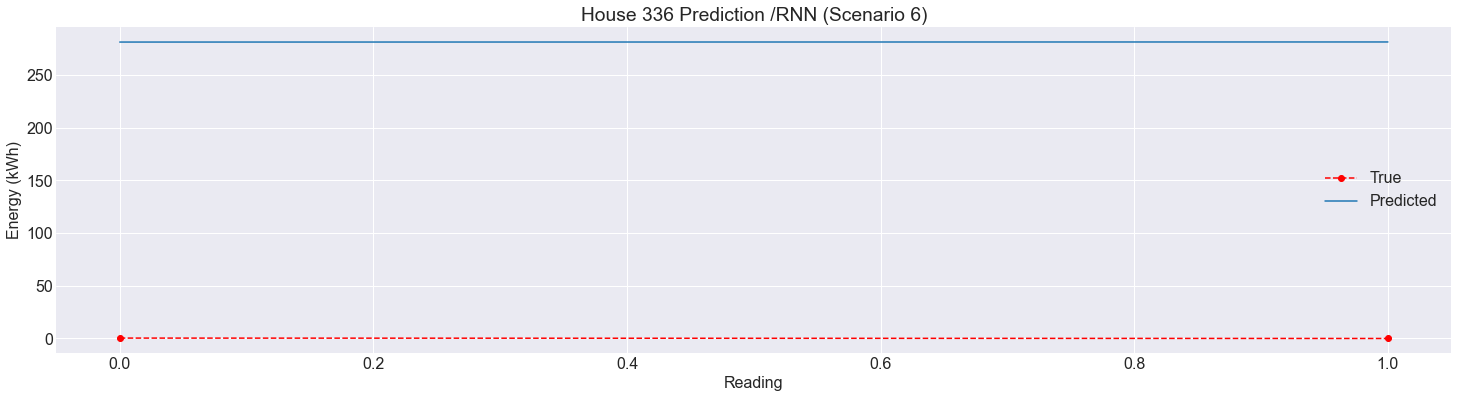

Mse:  69570.586132042997633
Rmse: 263.762366785034374
Mae:  263.761905759572983
Mape:  100.102850067295762


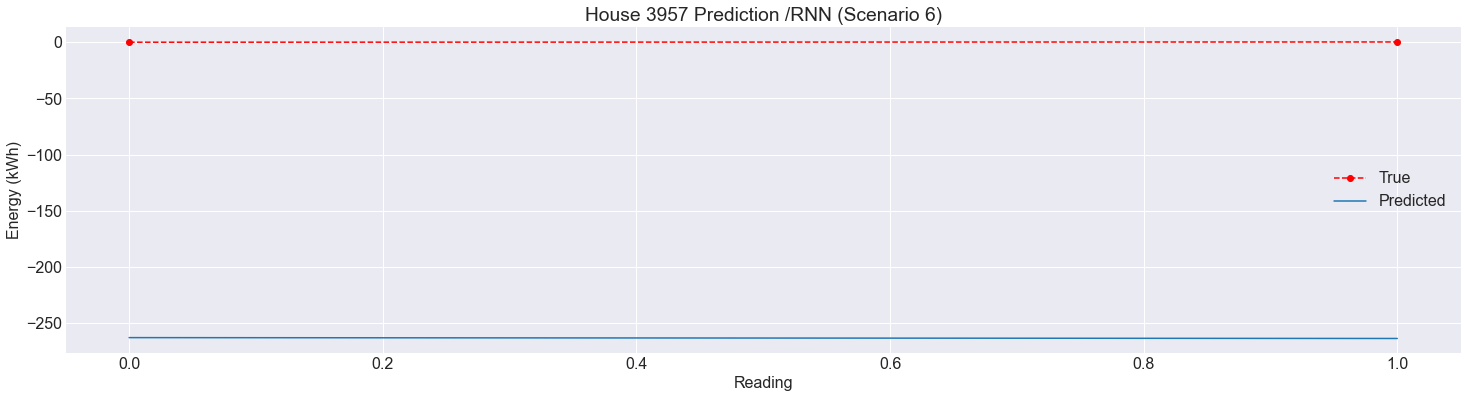

Mse:  103619.301080149714835
Rmse: 321.899520161415751
Mae:  321.899443723261356
Mape:  100.036204553149503


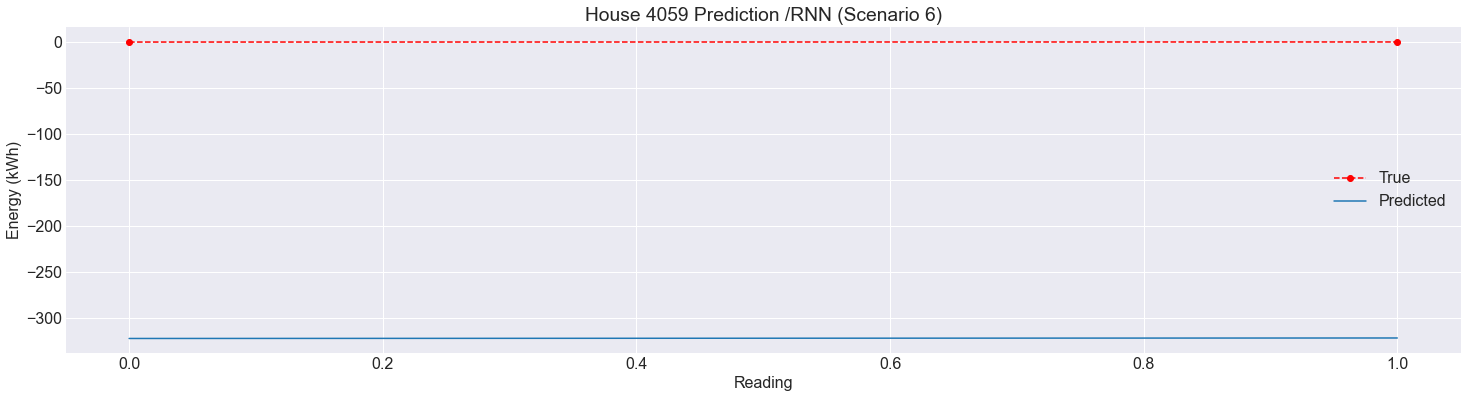

Mse:  31970.501365663483739
Rmse: 178.802968000152276
Mae:  178.802967834286392
Mape:  99.993009553164526


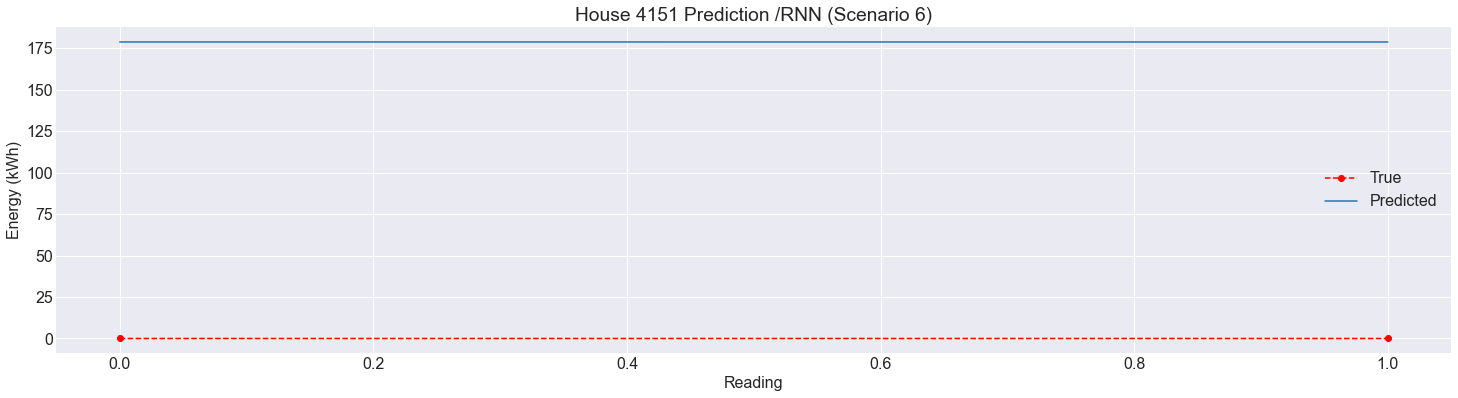

Mse:  87320.959448119305307
Rmse: 295.501200417391374
Mae:  295.500801637768745
Mape:  100.063830915818059


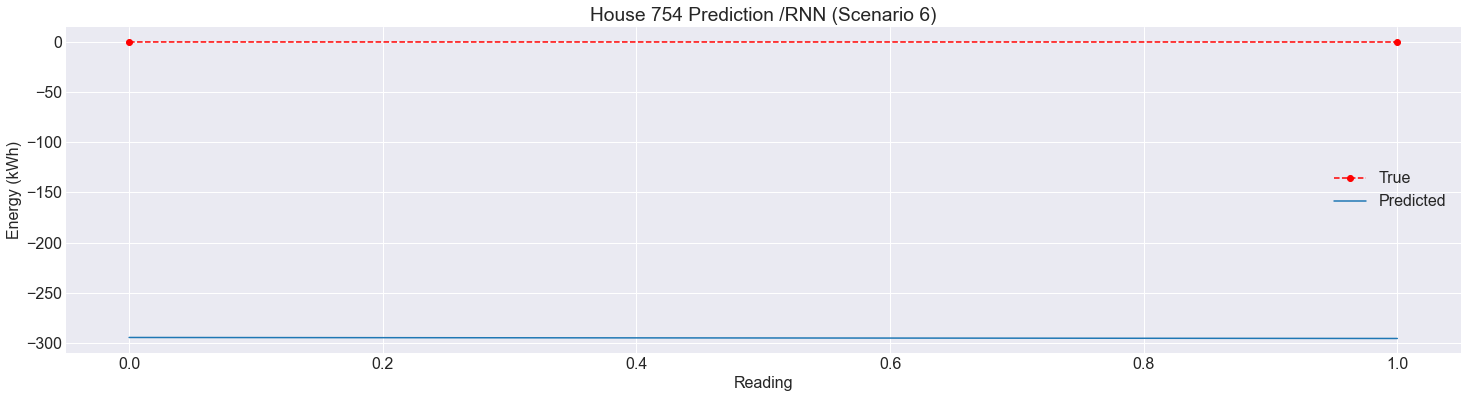

Mse:  10601.443714796245331
Rmse: 102.963312470006741
Mae:  102.963143732398748
Mape:  100.178049973653344


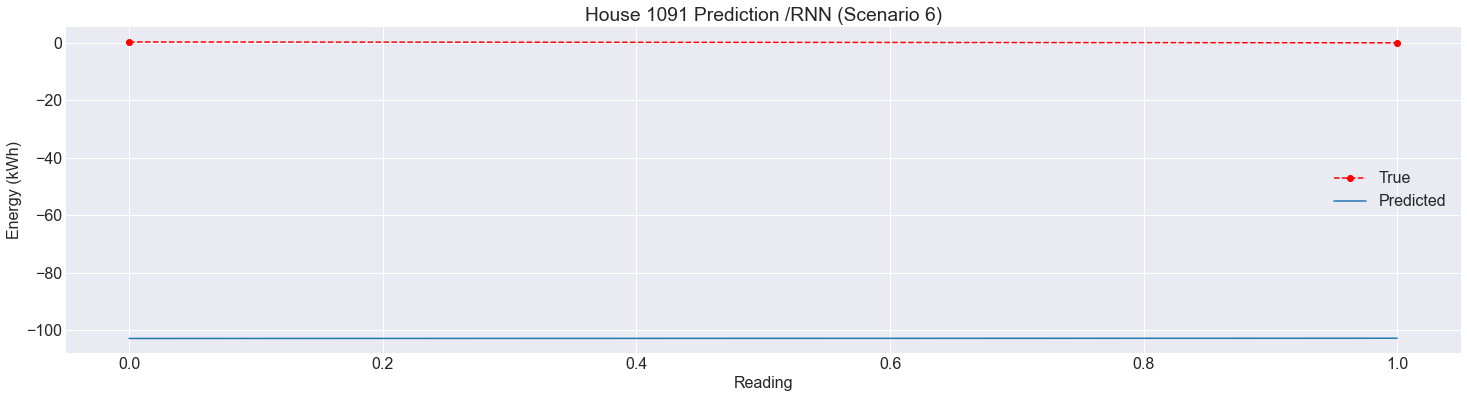

Mse:  22801.874817825053469
Rmse: 151.002896719980356
Mae:  151.002890684641898
Mape:  100.035773696897351


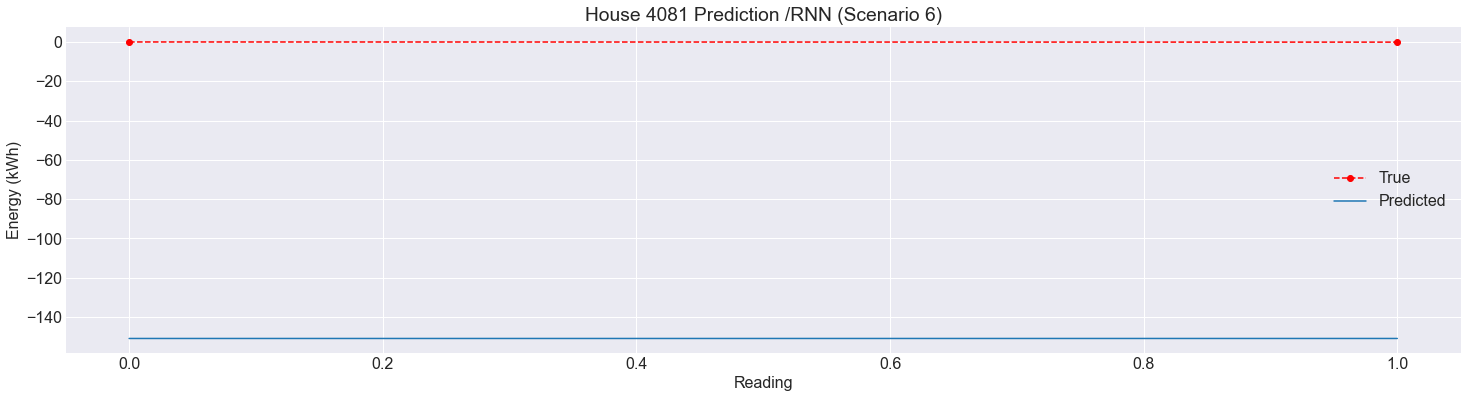

Mse:  6646.221231249264747
Rmse: 81.524359741424917
Mae:  81.520785797387362
Mape:  99.939310968146600


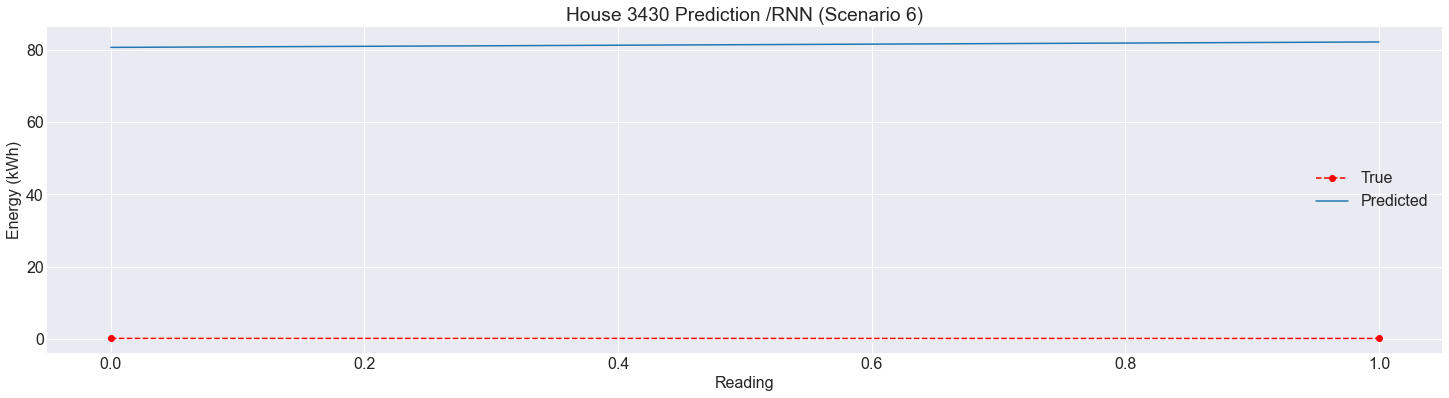

Mse:  88406.586449857888510
Rmse: 297.332451054132150
Mae:  297.332415036857128
Mape:  100.031792718436805


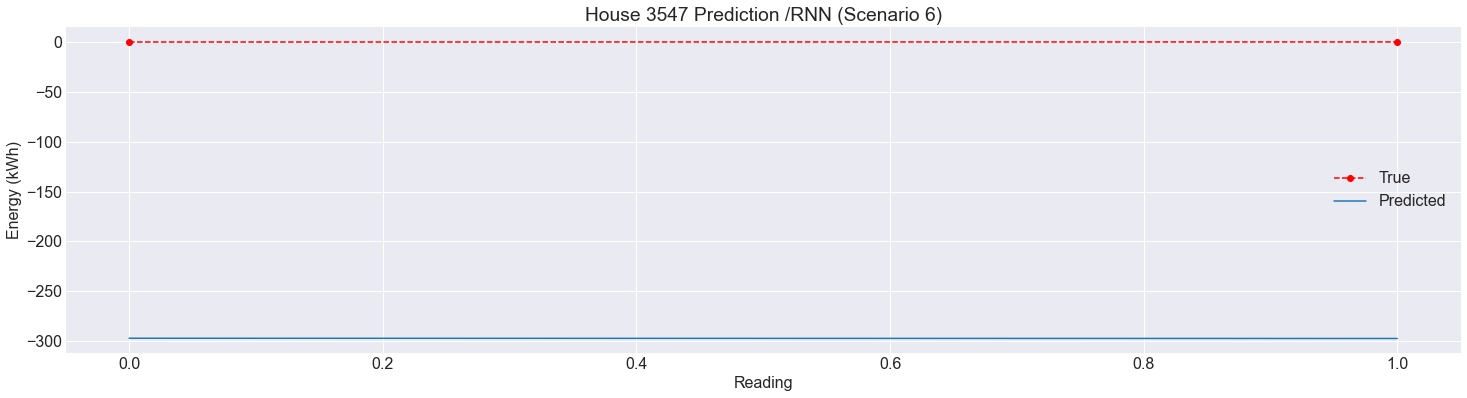

Mse:  198999.012243644567207
Rmse: 446.093053346097918
Mae:  446.092926632612944
Mape:  100.045414754293049


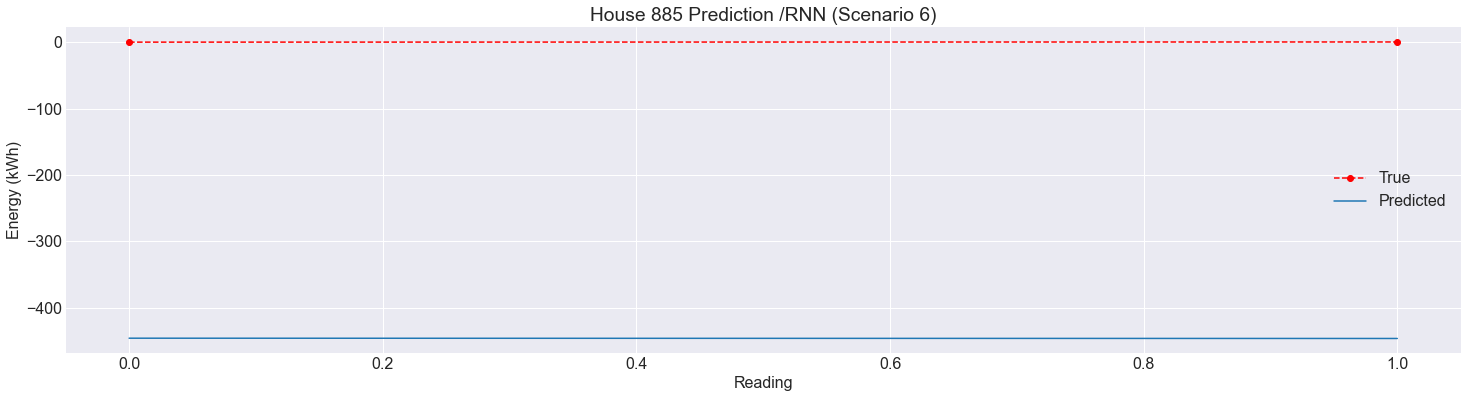

Mse:  18716.038153191871970
Rmse: 136.806572039474304
Mae:  136.806054931133986
Mape:  100.068392114854518


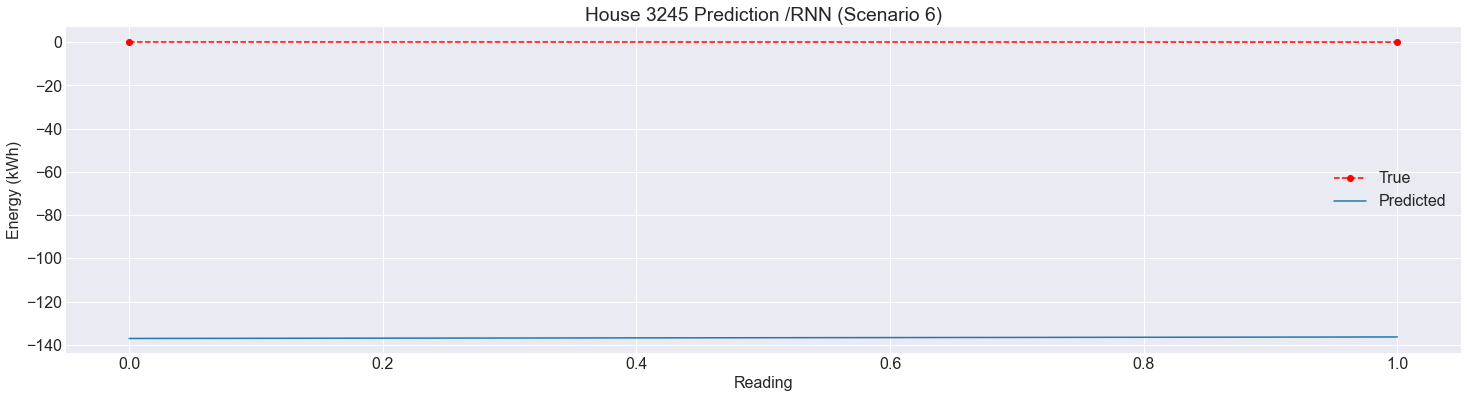

Mse:  37013.987131087953458
Rmse: 192.390194997270982
Mae:  192.370945625007153
Mape:  99.881595843096434


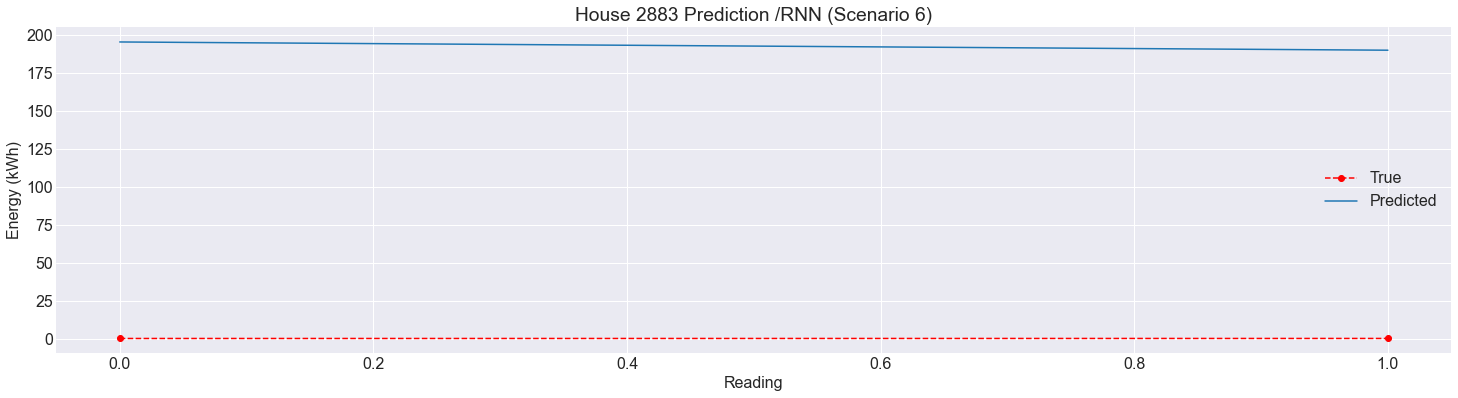

Mse:  1972.556178718908313
Rmse: 44.413468438289172
Mae:  44.413467651233077
Mape:  100.126247063782898


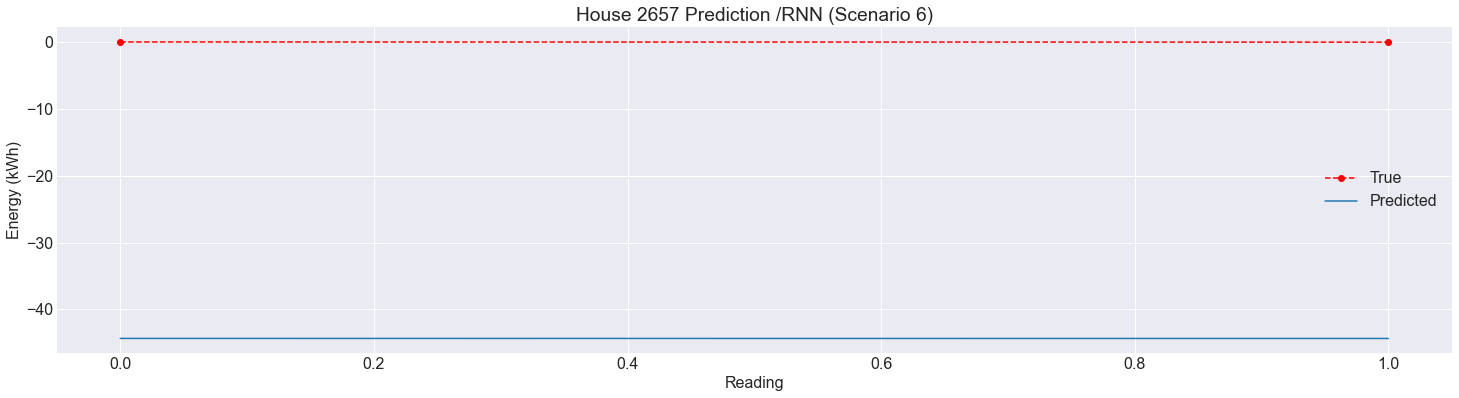

Mse:  31566.503254518145695
Rmse: 177.669646407365121
Mae:  177.668935302644968
Mape:  100.079706458054886


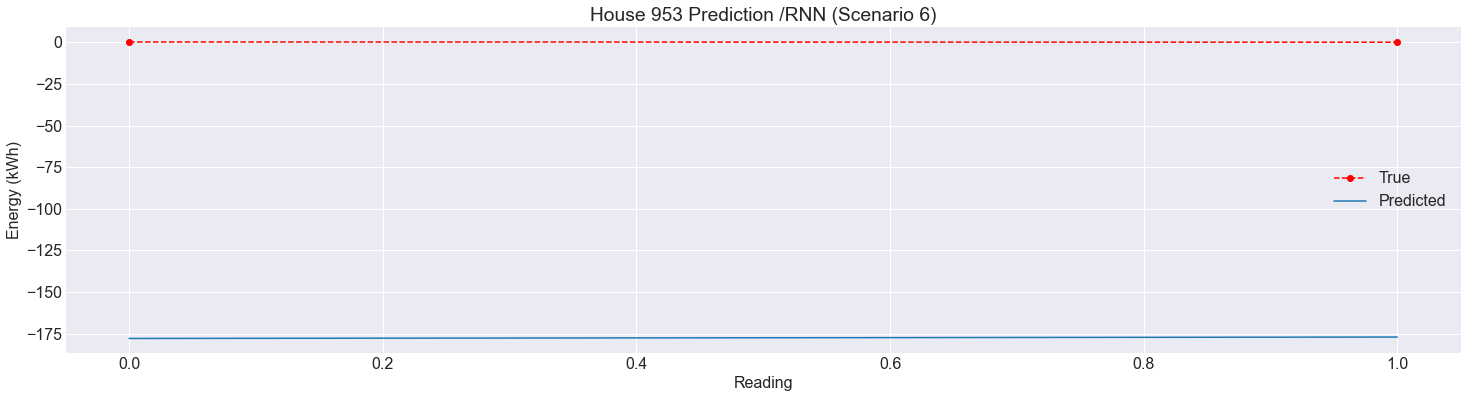

Mse:  46949.358115141556482
Rmse: 216.678005610033154
Mae:  216.677714962512255
Mape:  100.051023535947877


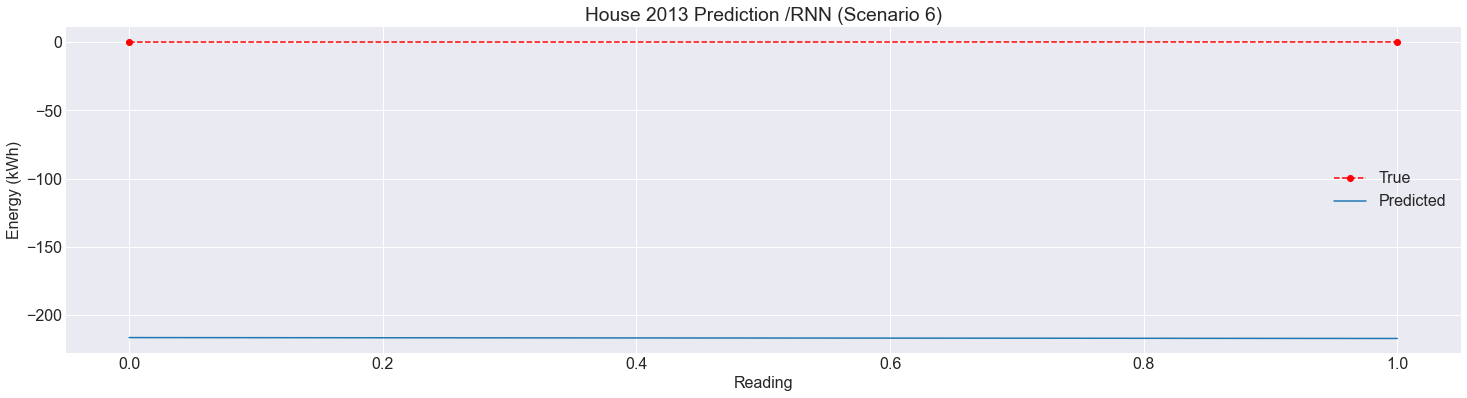

Mse:  38865.652309060737025
Rmse: 197.143735150424533
Mae:  197.143734314478934
Mape:  100.007355581057311


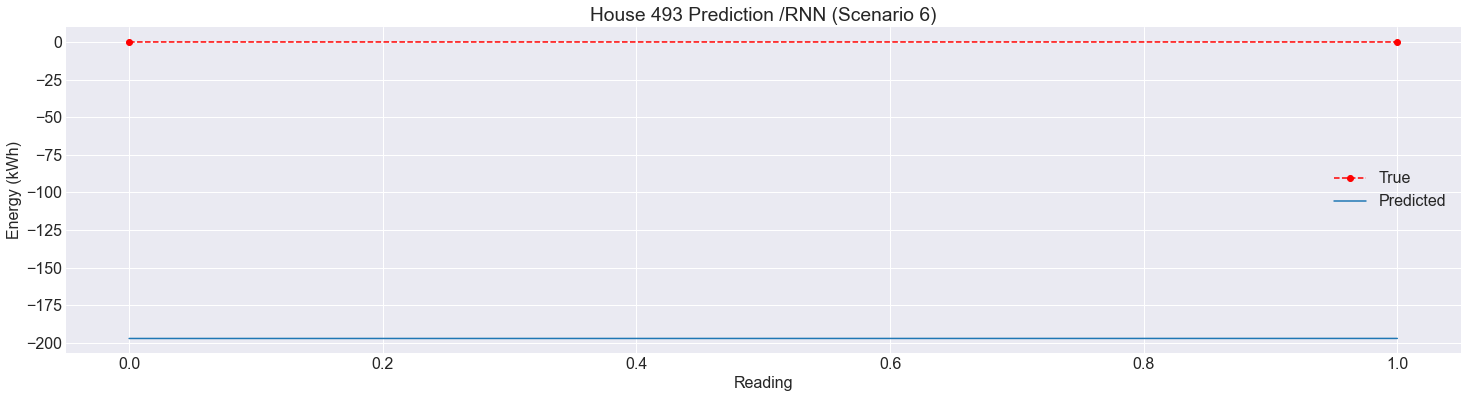

Mse:  492.257310585437949
Rmse: 22.186872483192353
Mae:  22.181853450834751
Mape:  101.454747657884909


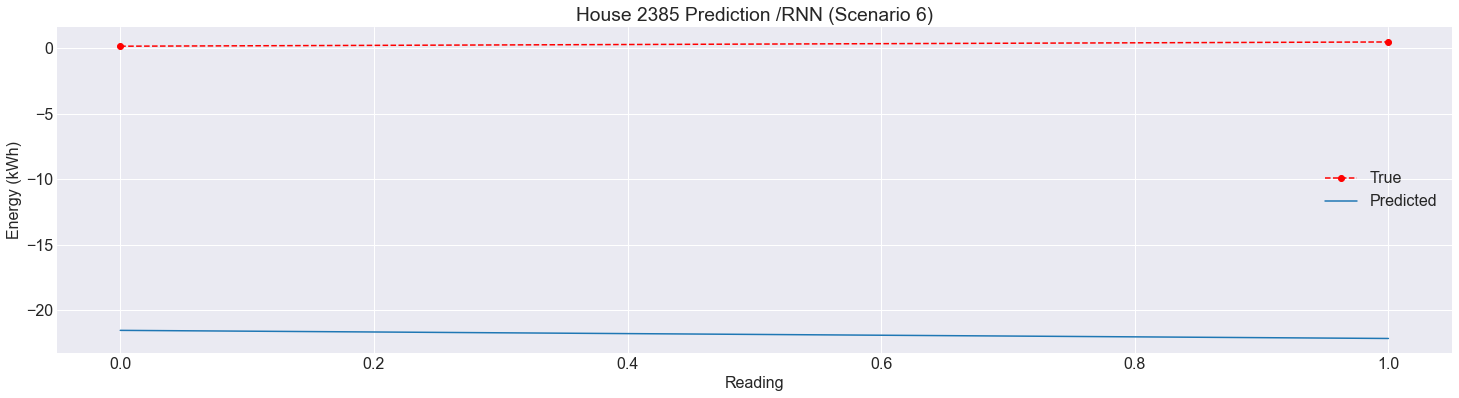

Mse:  22314.686331271361269
Rmse: 149.381010611360381
Mae:  149.379068482667208
Mape:  100.100183306989749


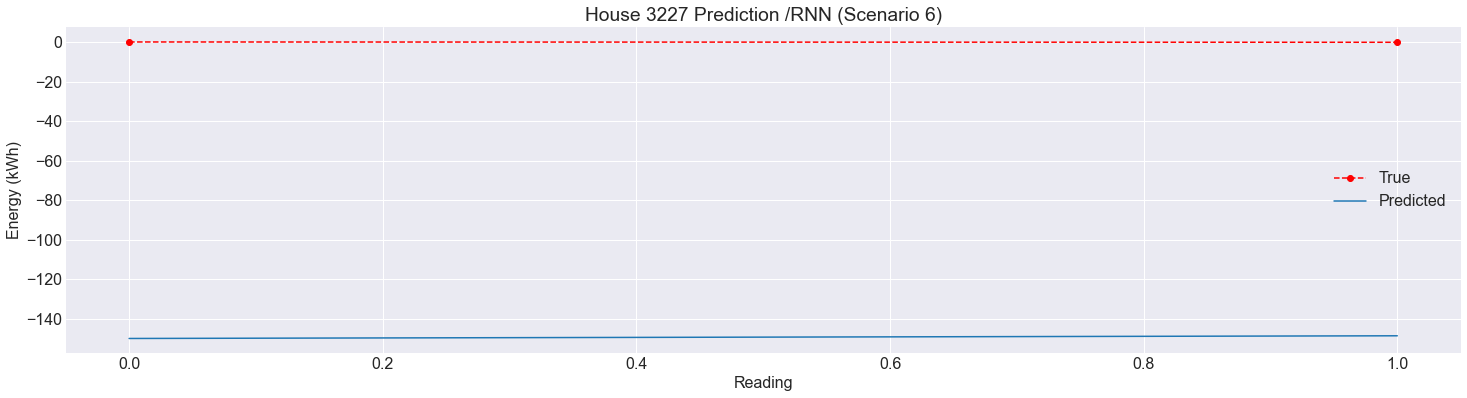

Mse:  165793.016053688887041
Rmse: 407.176885460961387
Mae:  407.176822761073709
Mape:  99.928460698221627


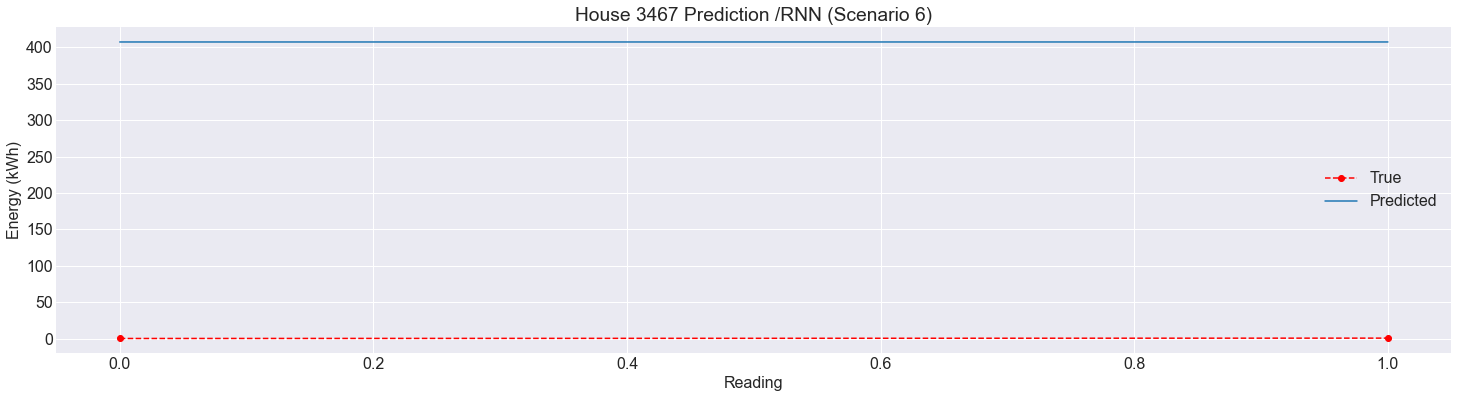

Mse:  63900.046102894310025
Rmse: 252.784584385389905
Mae:  252.784039378166199
Mape:  99.803183217523880


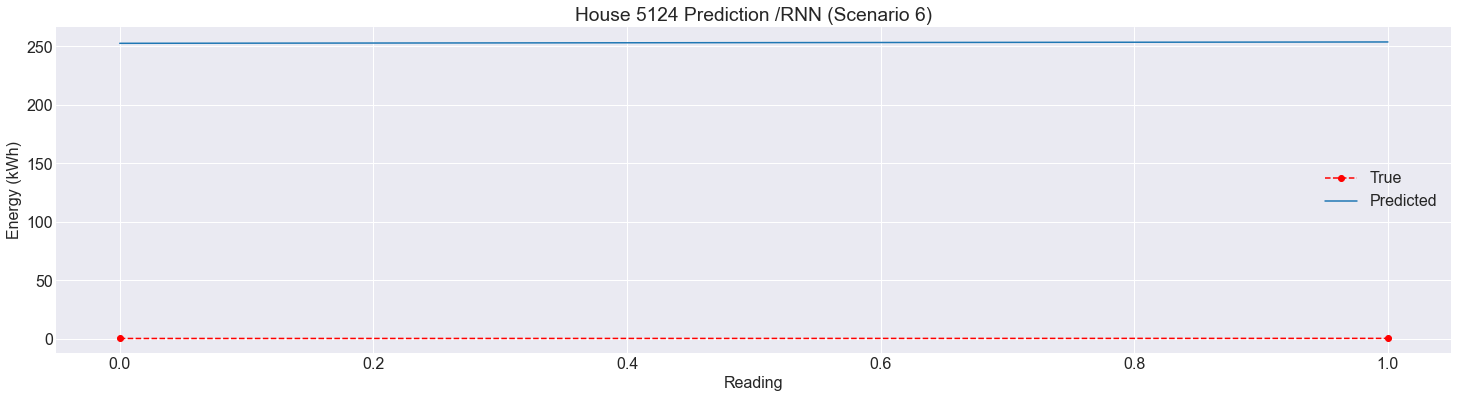

Mse:  4894.245188138373123
Rmse: 69.958882124705028
Mae:  69.958870977163315
Mape:  99.538297598904620


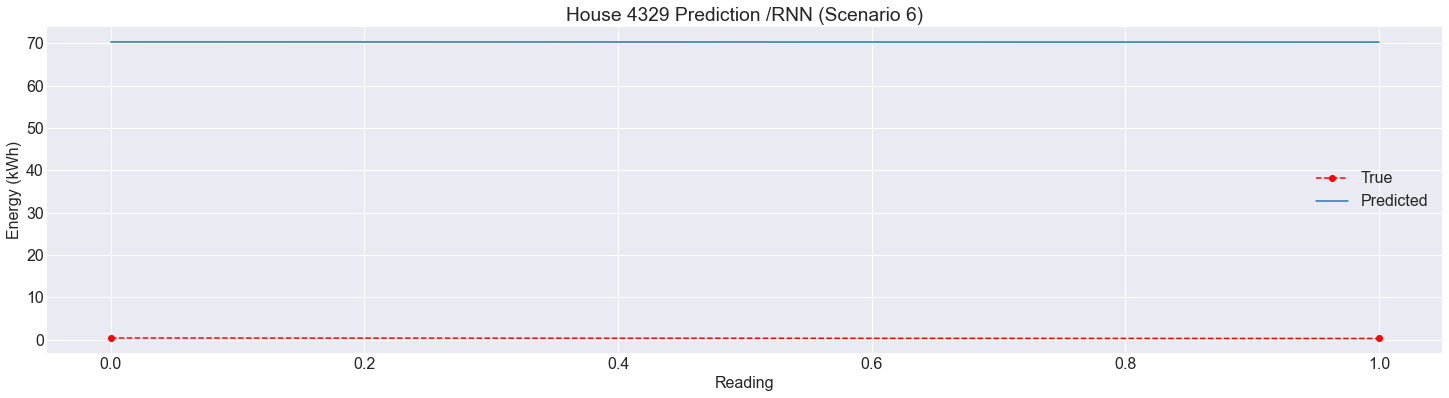

In [98]:
 ##### The households with an error have a '#' 
predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)


In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,86.435259,4608.621813,62258.326279,109.196483,19856.205259,78466.279368,63180.907938,529275.601113,5820.002769,196548.697428,...,24514.598351,77316.159608,8337.416690,5931.090148,30083.877776,14079.099847,16895.415903,177890.541176,2431.422753,65382.557775
RMSE_scores,9.297056,67.886831,249.516184,10.449712,140.912048,280.118331,251.358127,727.513300,76.288943,443.338130,...,156.571384,278.057835,91.309456,77.013571,173.447046,118.655383,129.982368,421.770721,49.309459,255.700133
MAE_scores,9.296951,67.883364,249.516181,10.449416,140.912048,280.118320,251.358126,727.513294,76.288929,443.338039,...,156.568417,278.057831,91.309435,77.012657,173.447033,118.655167,129.978624,421.770626,49.309417,255.700118
MAPE_scores,101.357328,99.772167,99.868518,98.533699,99.969494,100.036784,100.043184,99.990448,100.272735,99.938910,...,99.854583,100.020144,99.845272,100.143692,100.008361,99.732713,100.115157,100.069161,101.021293,100.127068


In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario2_1h.csv', index=False)

In [ ]:
## Best regression model

In [99]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [100]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 6)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario6/2_singleHouseholdLevel/best_regression_model/S6_1h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  0.001526402223456
Rmse: 0.039069197886005
Mae:  0.030009432446166
Mape:  20.239768187205932


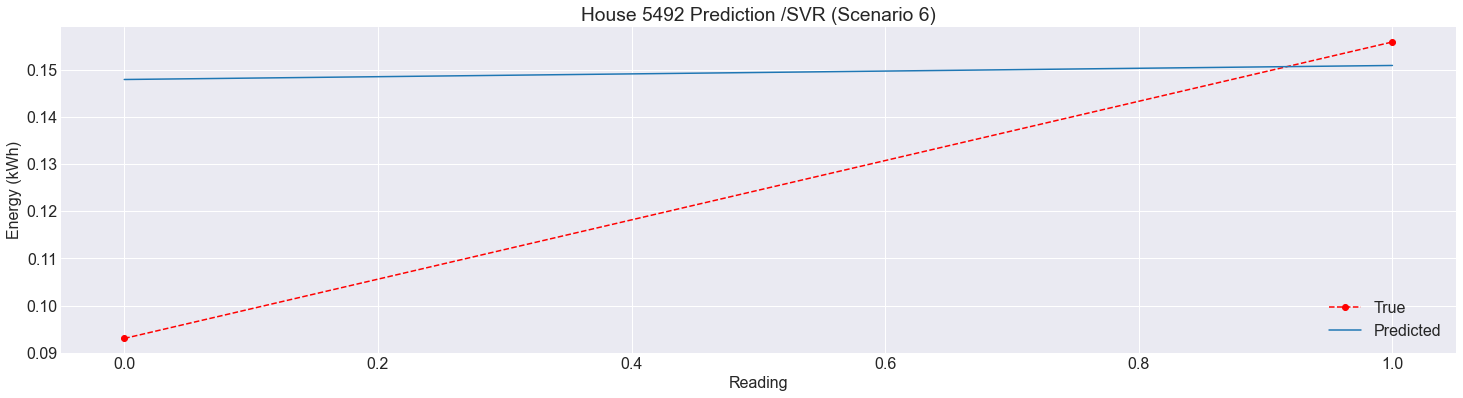

Mse:  0.007457500602988
Rmse: 0.086356821403919
Mae:  0.084181316007644
Mape:  514.681750702370778


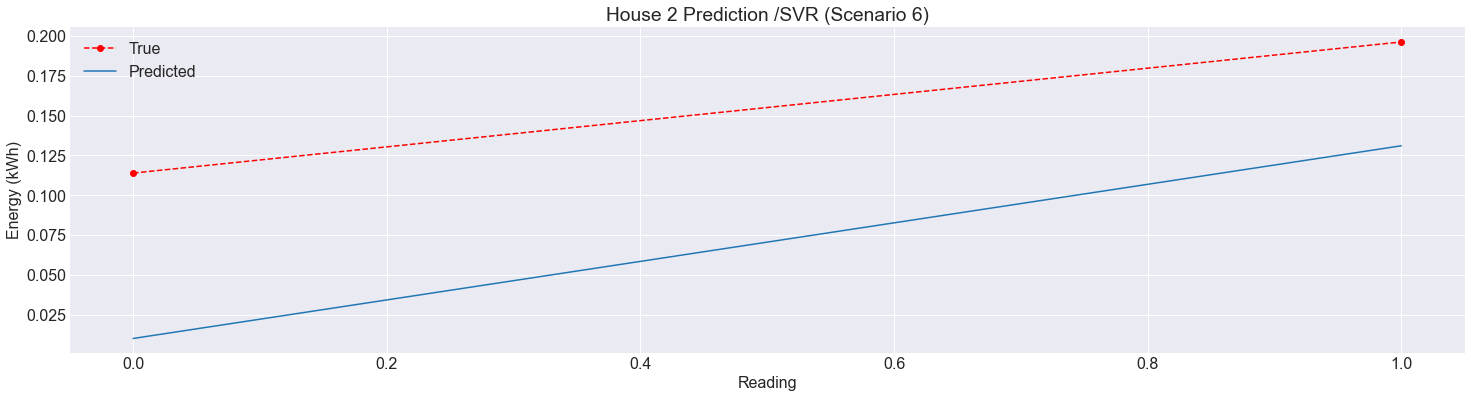

Mse:  0.078836086905152
Rmse: 0.280777646733410
Mae:  0.265549644984950
Mape:  43.765028282411109


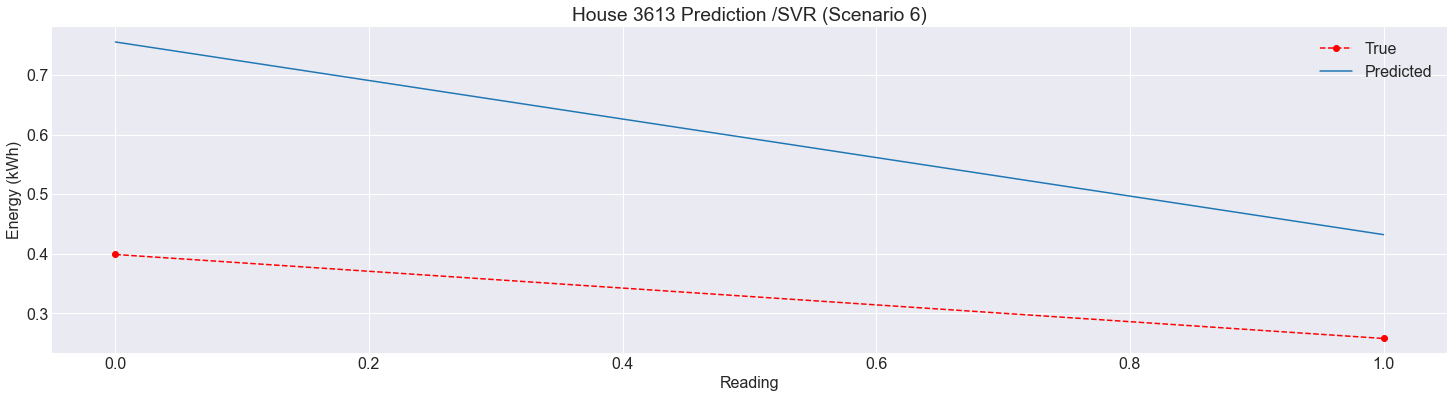

Mse:  0.005640223107659
Rmse: 0.075101418812559
Mae:  0.054727284010579
Mape:  42.355597005338112


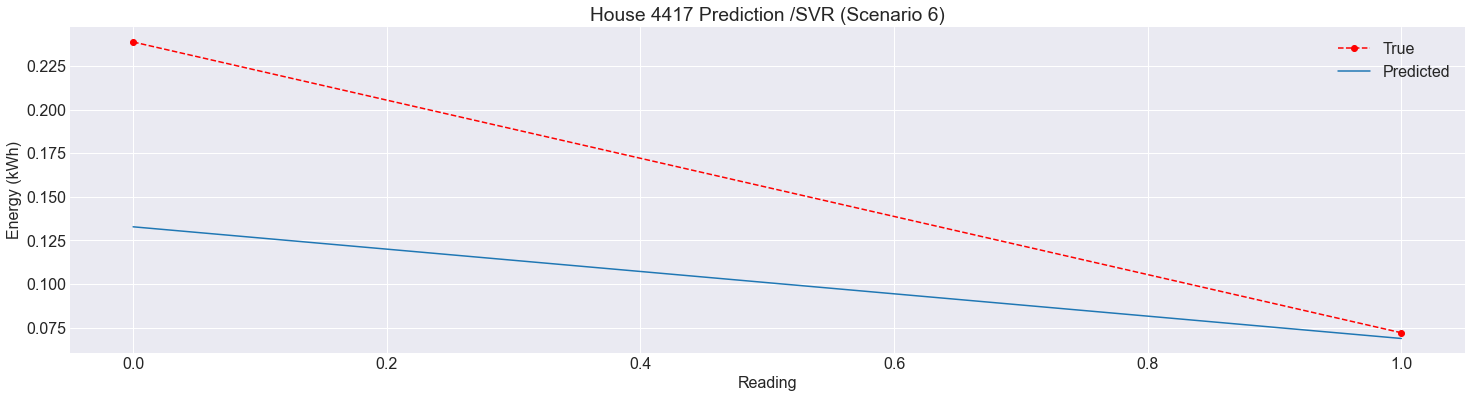

Mse:  0.000198867201020
Rmse: 0.014102028259079
Mae:  0.011964230672722
Mape:  23.718531853841228


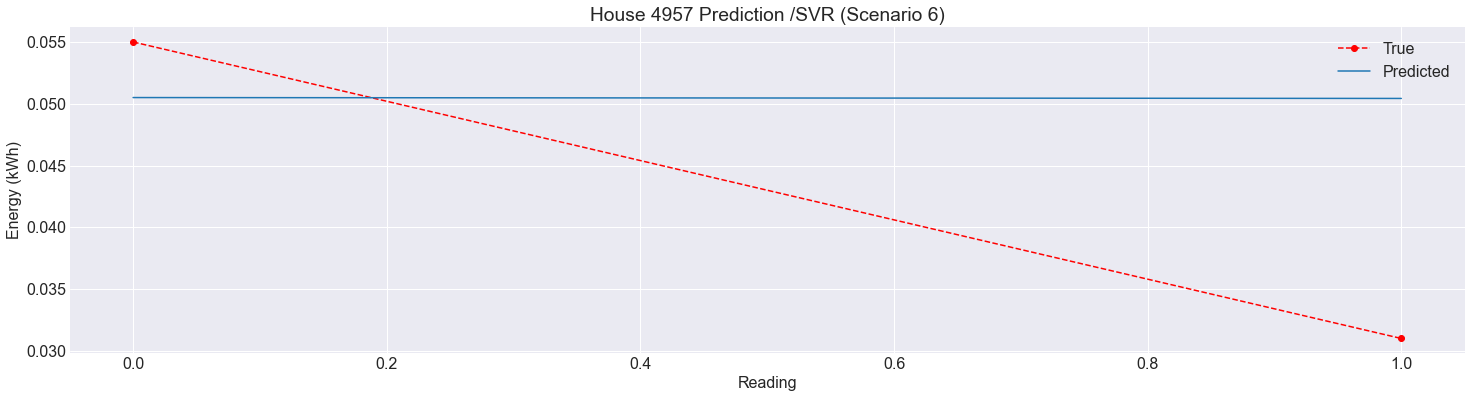

Mse:  0.001590527506814
Rmse: 0.039881418064230
Mae:  0.039859865099526
Mape:  39.188278400313294


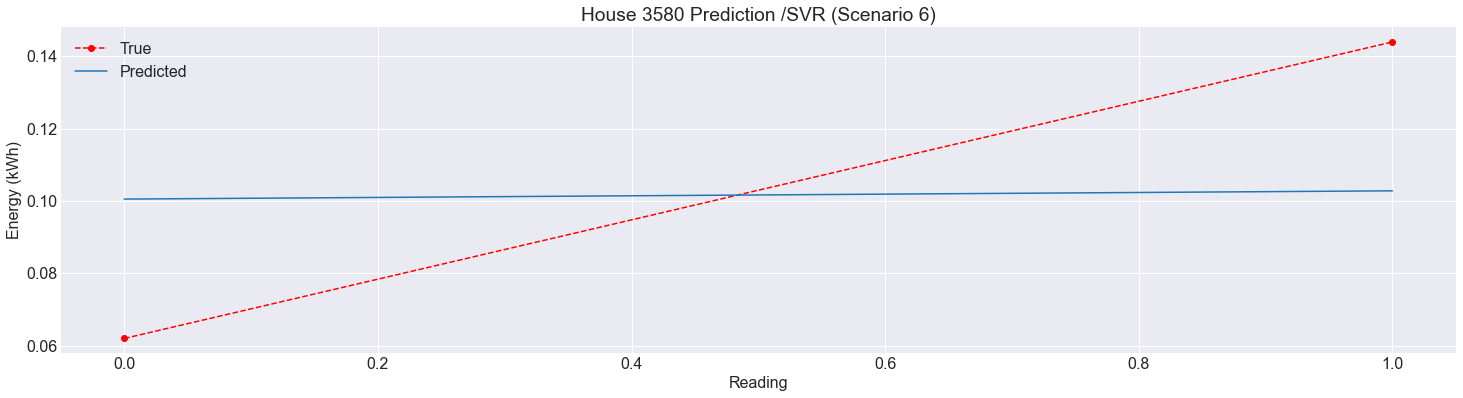

Mse:  0.109836219303213
Rmse: 0.331415478369996
Mae:  0.305461007359020
Mape:  73.093719304942994


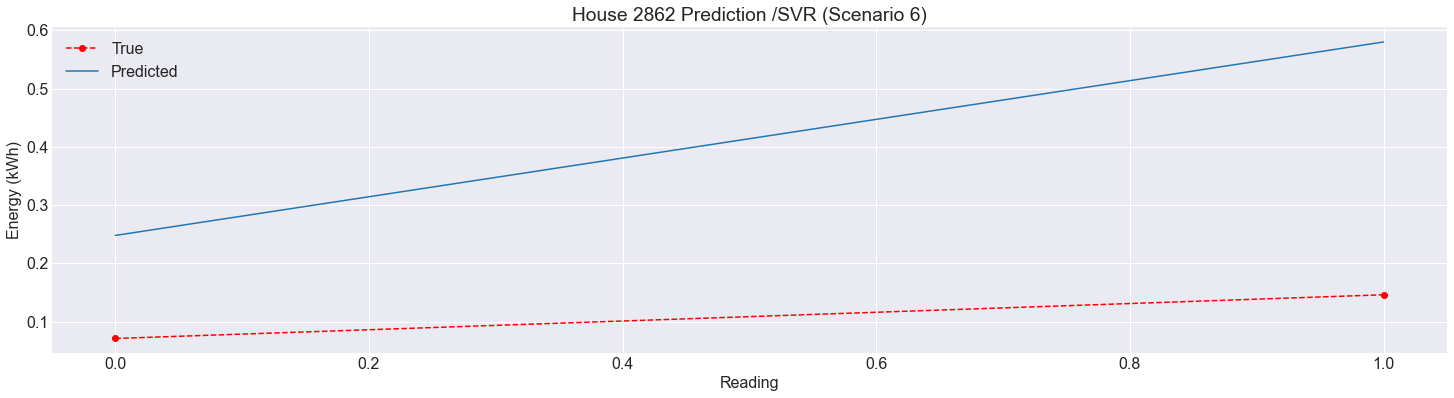

Mse:  0.002607788132497
Rmse: 0.051066506954135
Mae:  0.050857517719357
Mape:  44.054003284497078


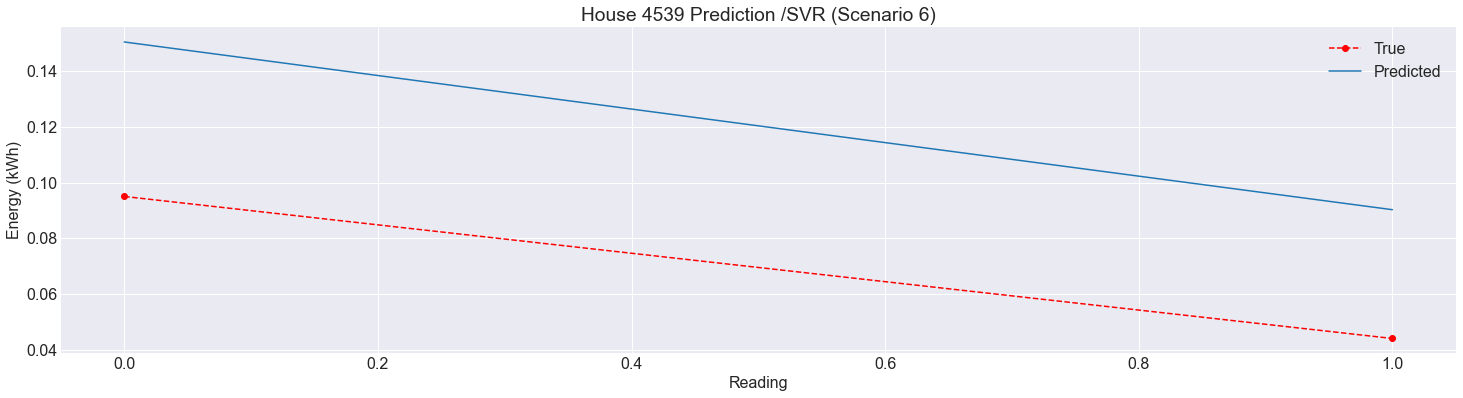

Mse:  0.013207469103073
Rmse: 0.114923753432756
Mae:  0.107660775299376
Mape:  68.167730586470057


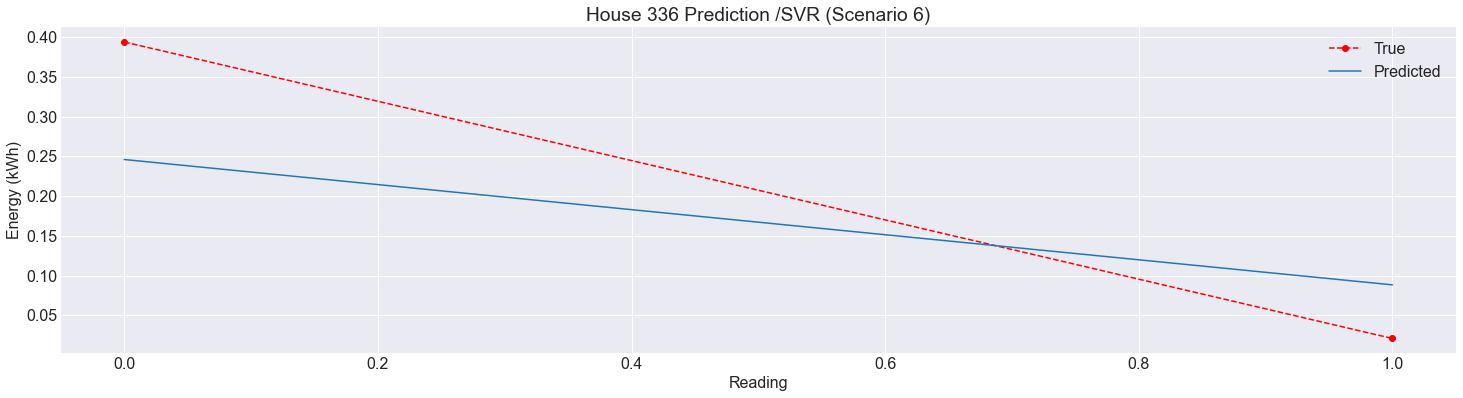

Mse:  0.013249127031626
Rmse: 0.115104852337450
Mae:  0.103857476268583
Mape:  46.419258431086192


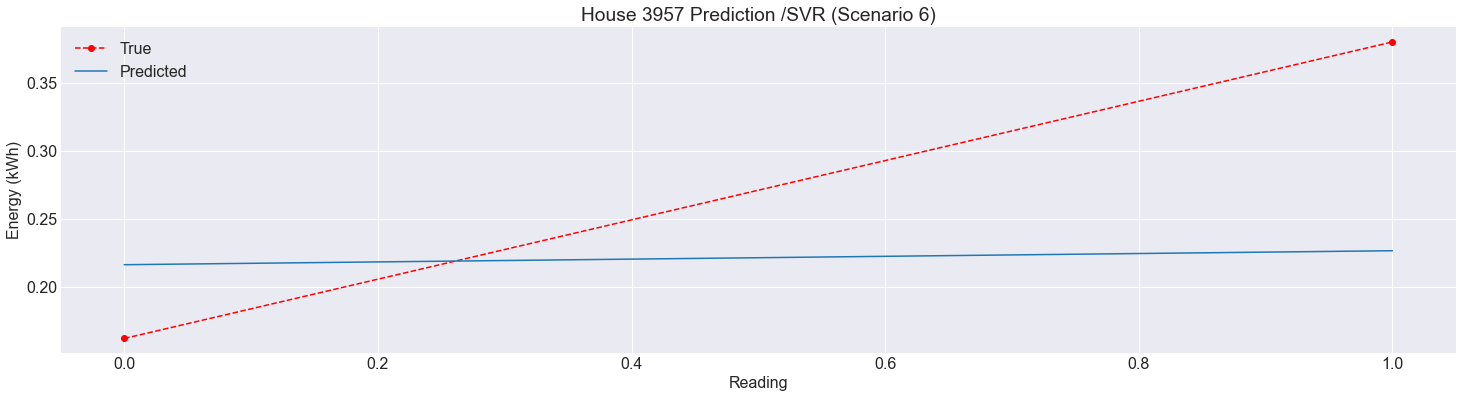

Mse:  0.003543069261273
Rmse: 0.059523686556474
Mae:  0.042999722693485
Mape:  27.356930535970093


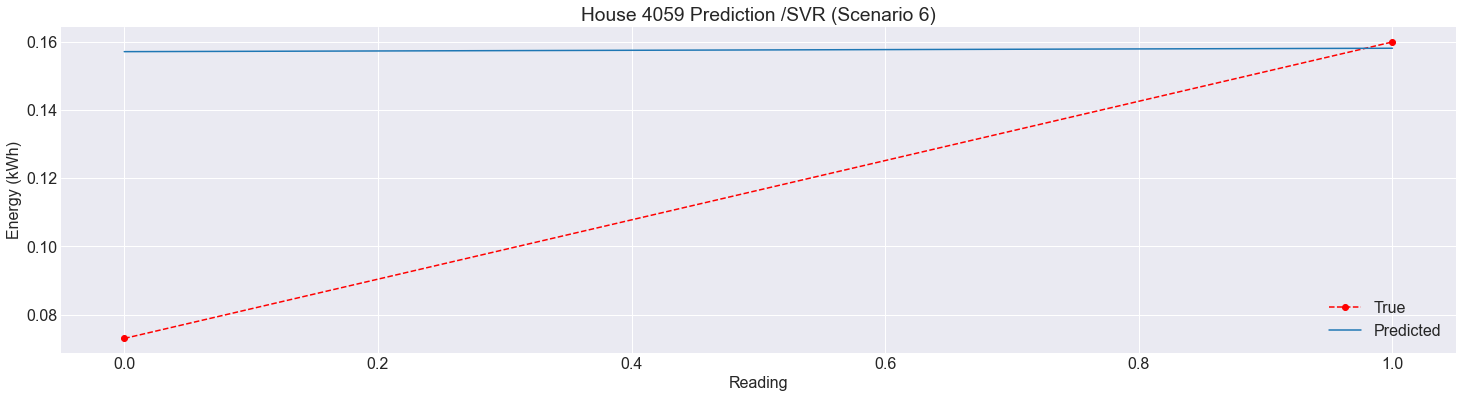

Mse:  0.004240596608571
Rmse: 0.065119863394902
Mae:  0.065116717212402
Mape:  83.894006399706683


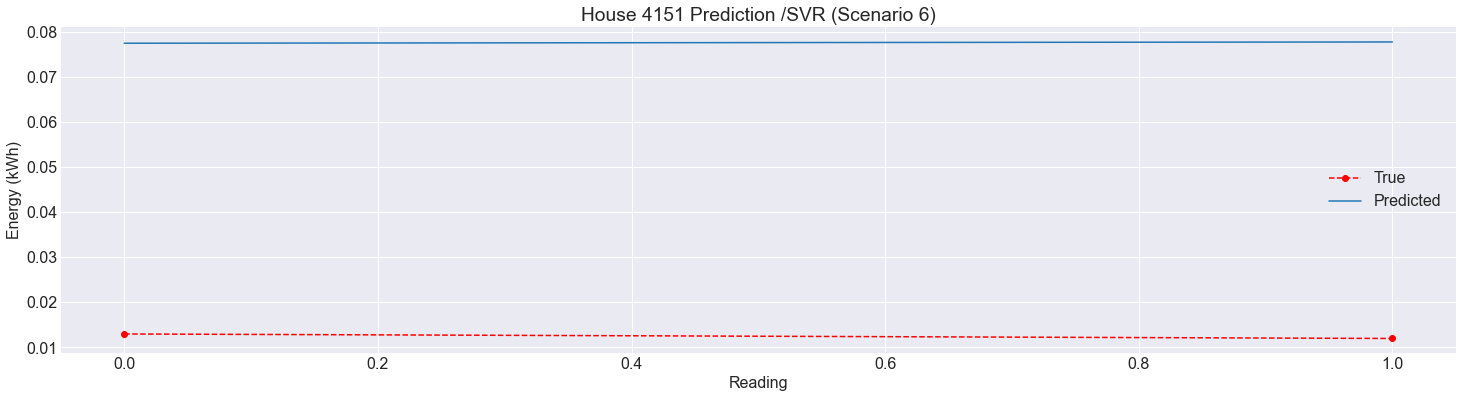

Mse:  0.002593918696044
Rmse: 0.050930528134351
Mae:  0.040621607590686
Mape:  29.742578055522827


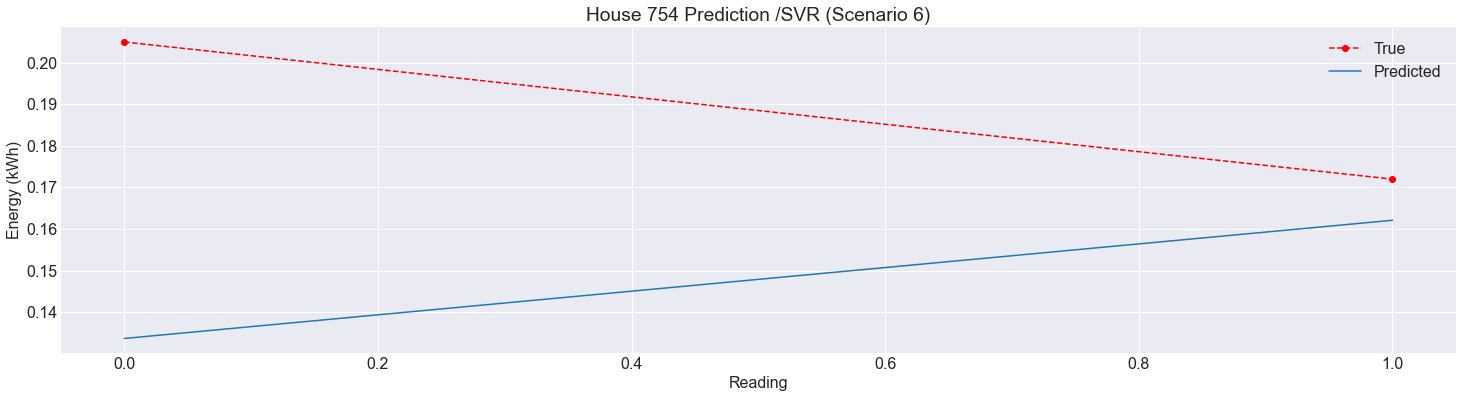

Mse:  0.020351275628144
Rmse: 0.142657897181136
Mae:  0.116394026108130
Mape:  99.664884966323015


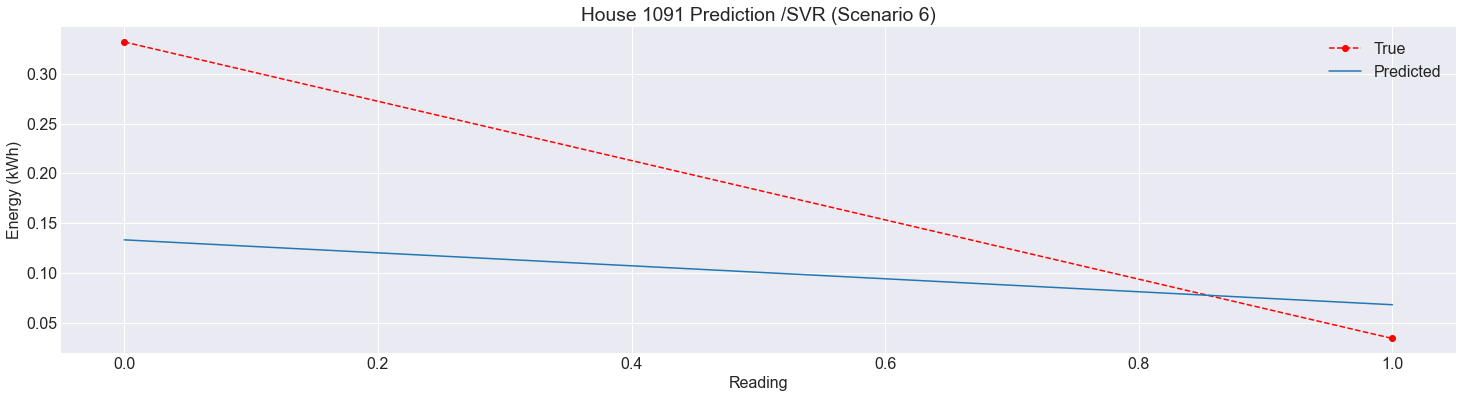

Mse:  0.005117969358310
Rmse: 0.071539984332608
Mae:  0.059420912347793
Mape:  52.439780692372864


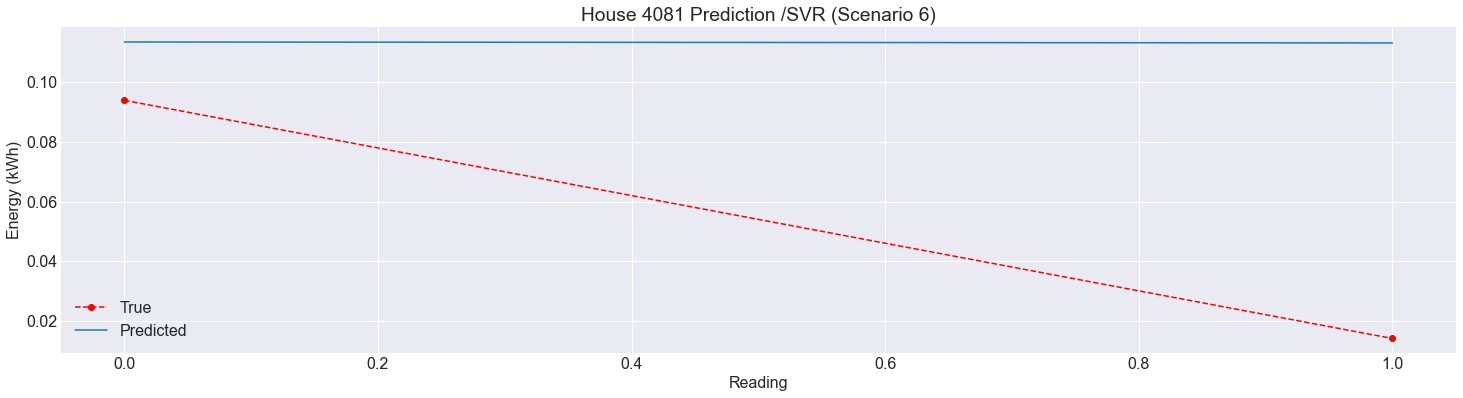

Mse:  0.004536344511441
Rmse: 0.067352390539912
Mae:  0.054276658439385
Mape:  44.020316665945380


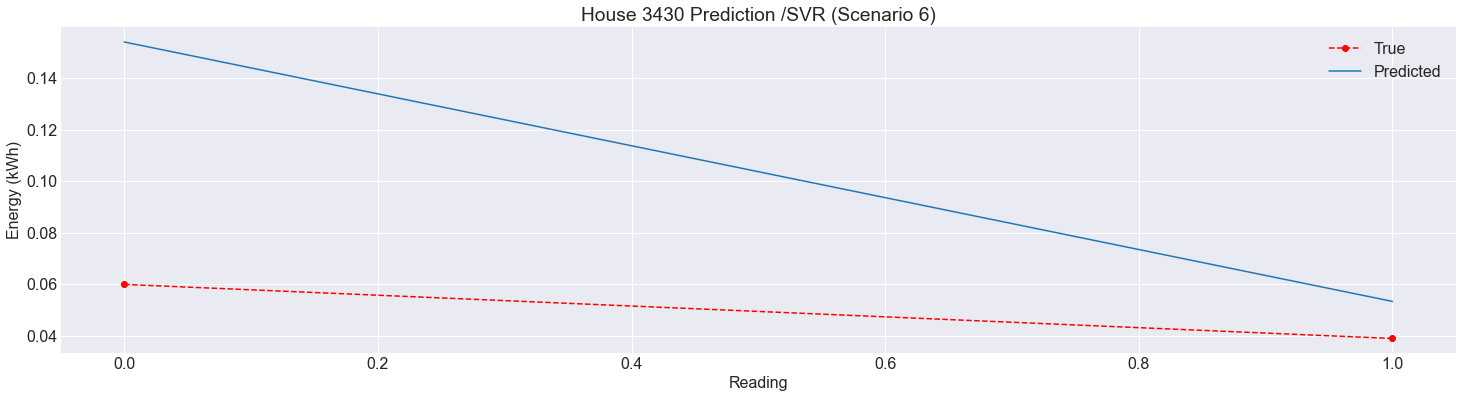

Mse:  0.026796876500379
Rmse: 0.163697515254139
Mae:  0.123370799854786
Mape:  118.892131706076711


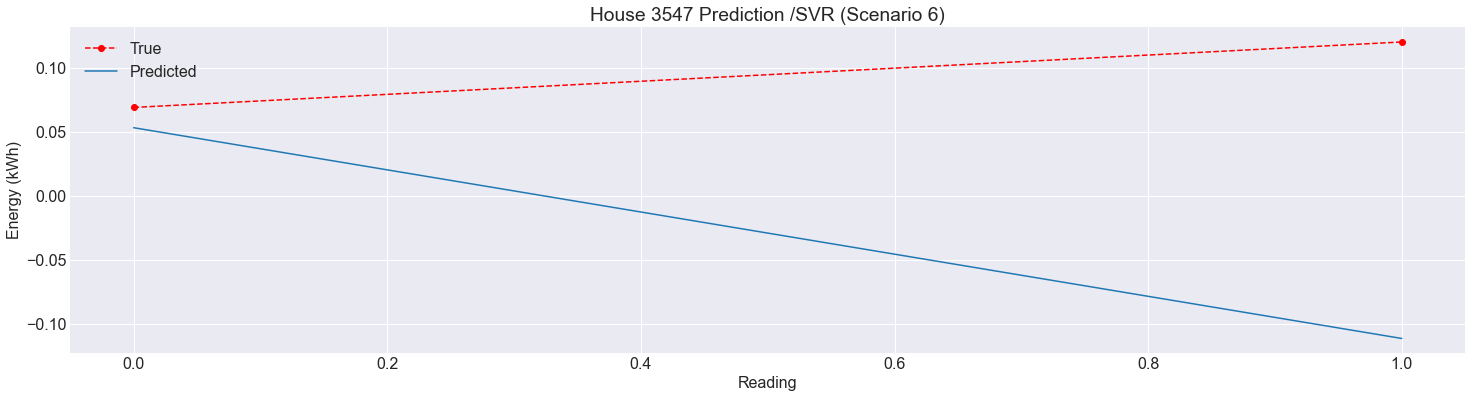

Mse:  0.211817954788536
Rmse: 0.460236846404692
Mae:  0.460164326975349
Mape:  72.171706673875818


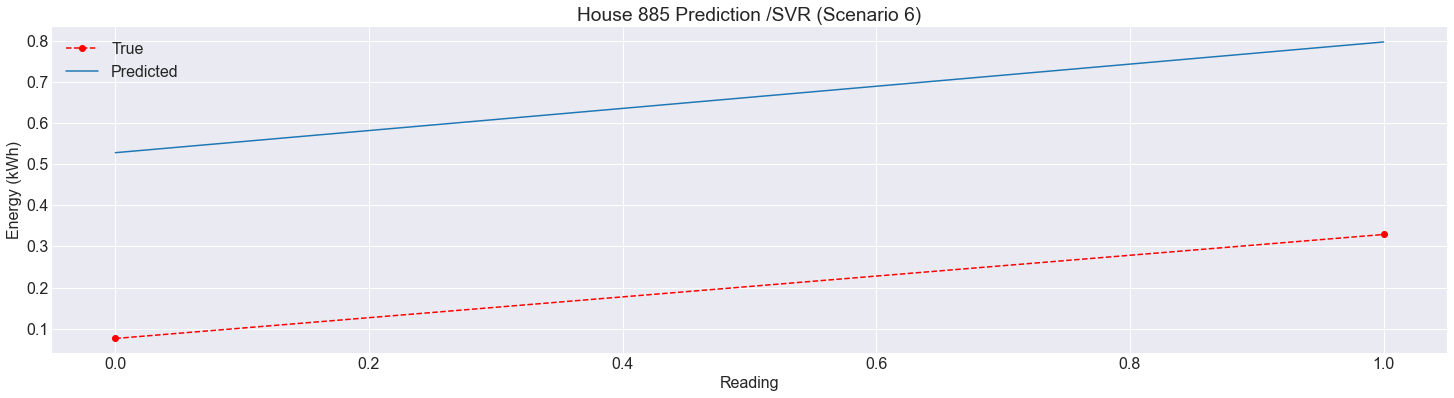

Mse:  0.009324337267115
Rmse: 0.096562608017362
Mae:  0.069156803142549
Mape:  97.494965506079311


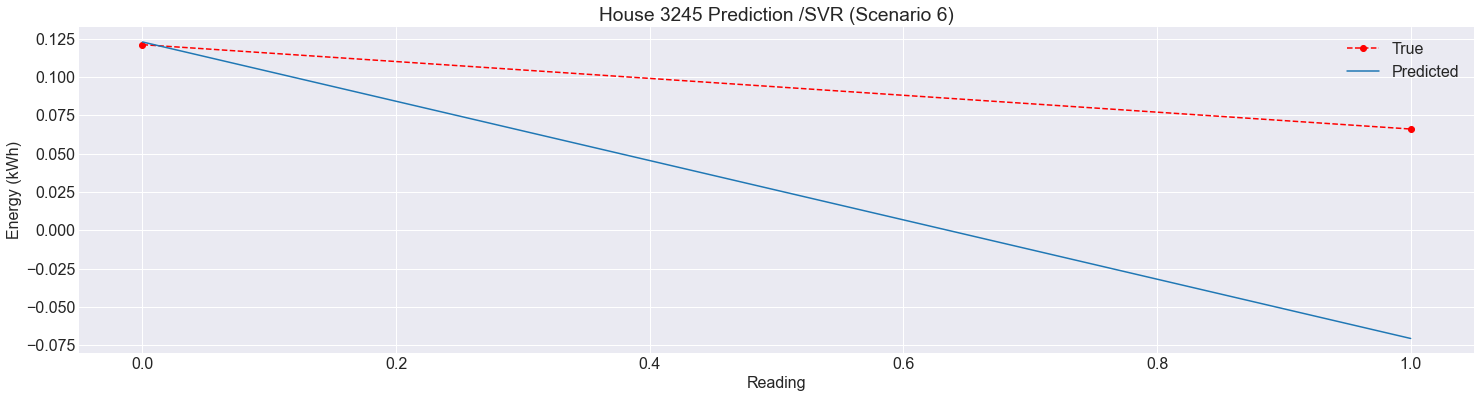

Mse:  0.005378983571006
Rmse: 0.073341554190011
Mae:  0.072721463738839
Mape:  24.198528668613861


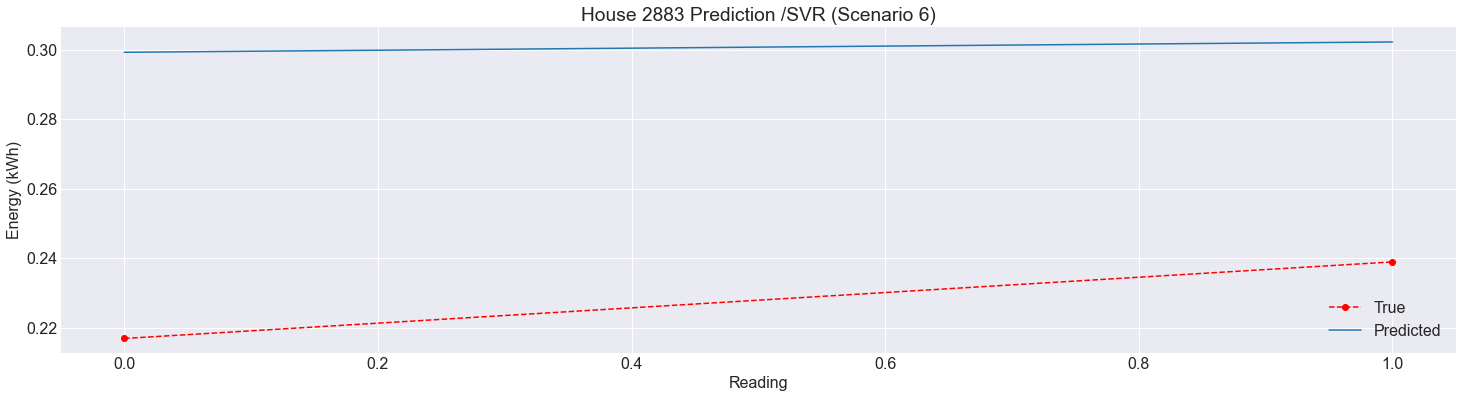

Mse:  0.009396977687088
Rmse: 0.096938009506530
Mae:  0.096153738941296
Mape:  63.233329583511519


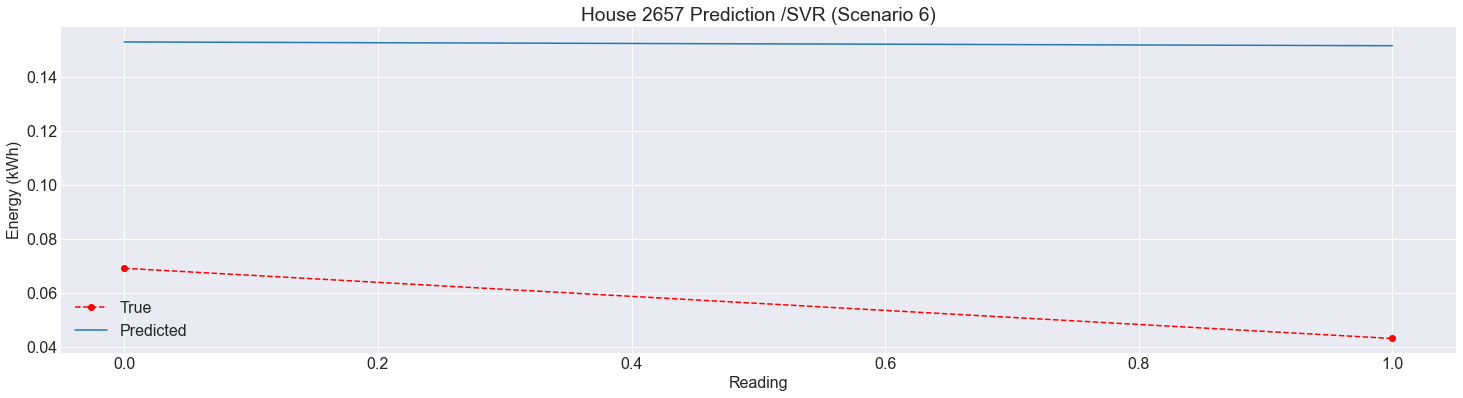

Mse:  0.005574194978795
Rmse: 0.074660531600000
Mae:  0.073097169933941
Mape:  57.933396819030577


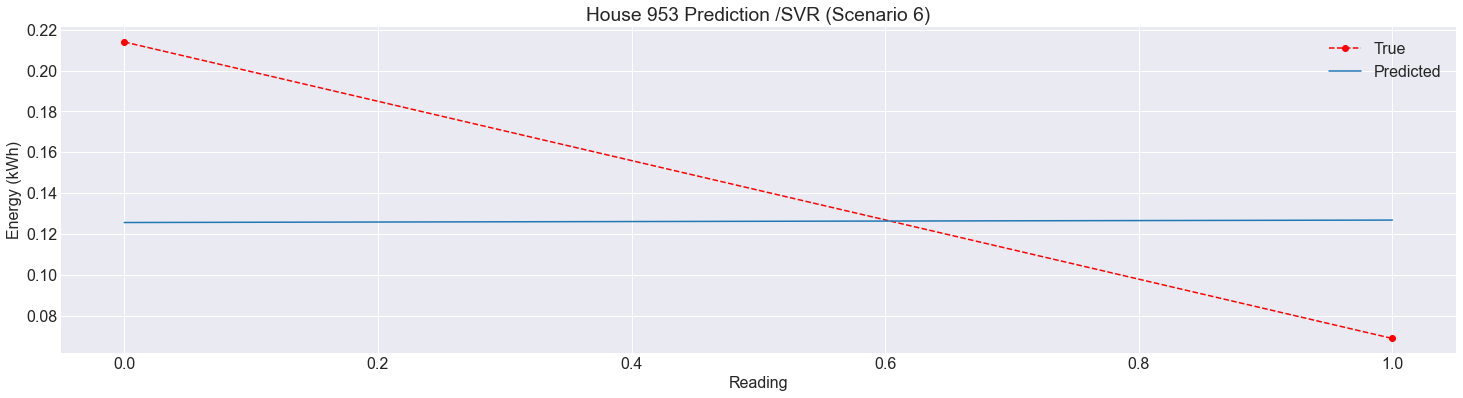

Mse:  0.000070617304112
Rmse: 0.008403410266794
Mae:  0.008046036024750
Mape:  9.259435125670040


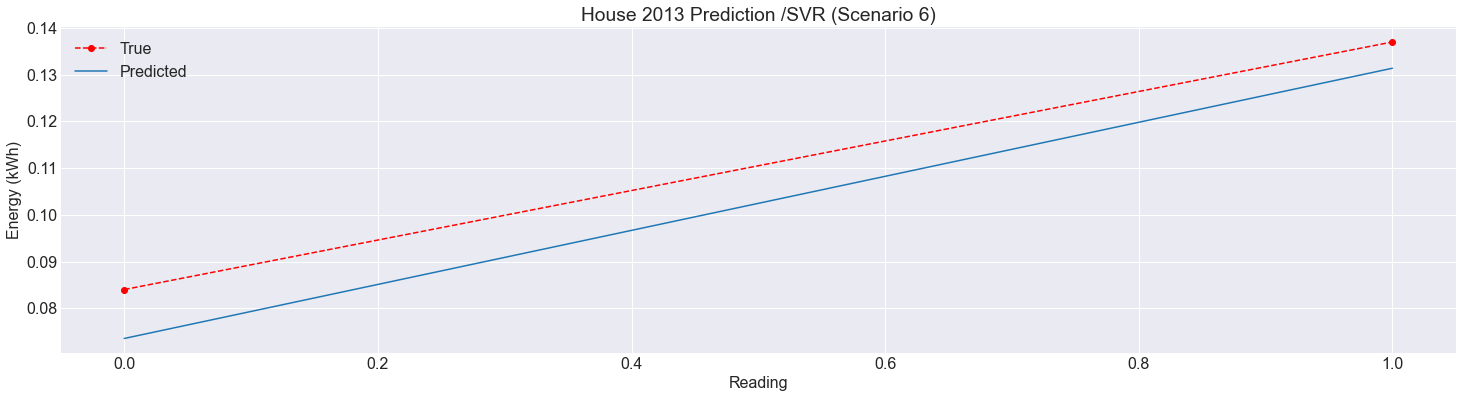

Mse:  0.017039308478143
Rmse: 0.130534702198854
Mae:  0.115724940363559
Mape:  86.323762437036592


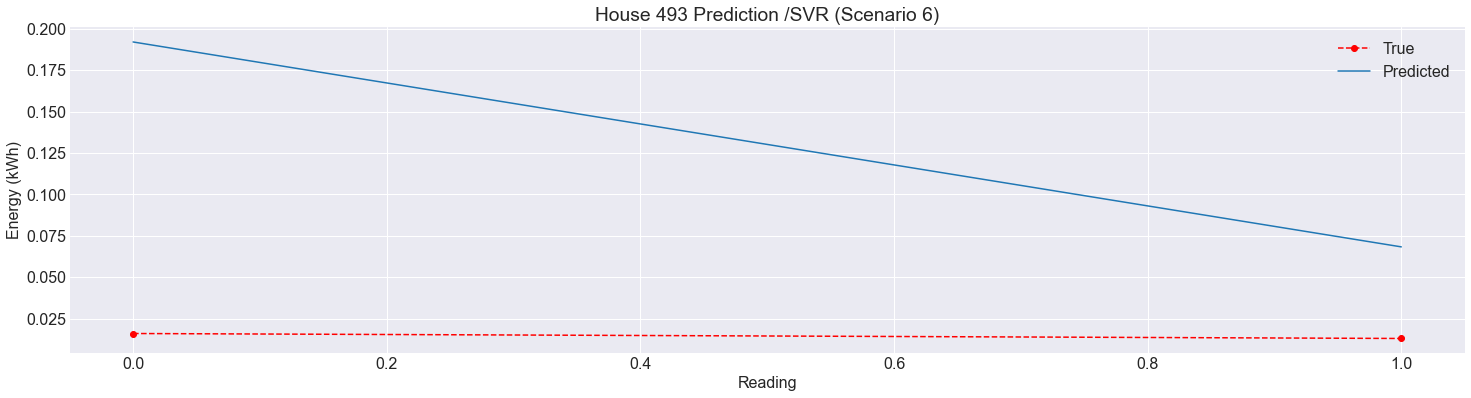

Mse:  0.014222240919843
Rmse: 0.119257037192121
Mae:  0.099915369720338
Mape:  29.083311723586782


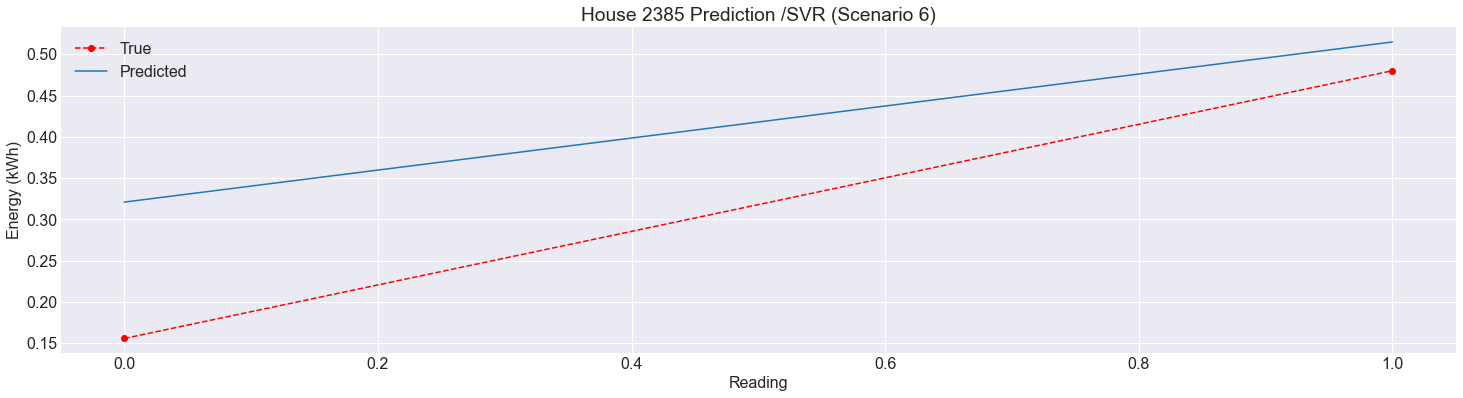

Mse:  0.010774161709553
Rmse: 0.103798659478592
Mae:  0.075203022892728
Mape:  34.791915558395921


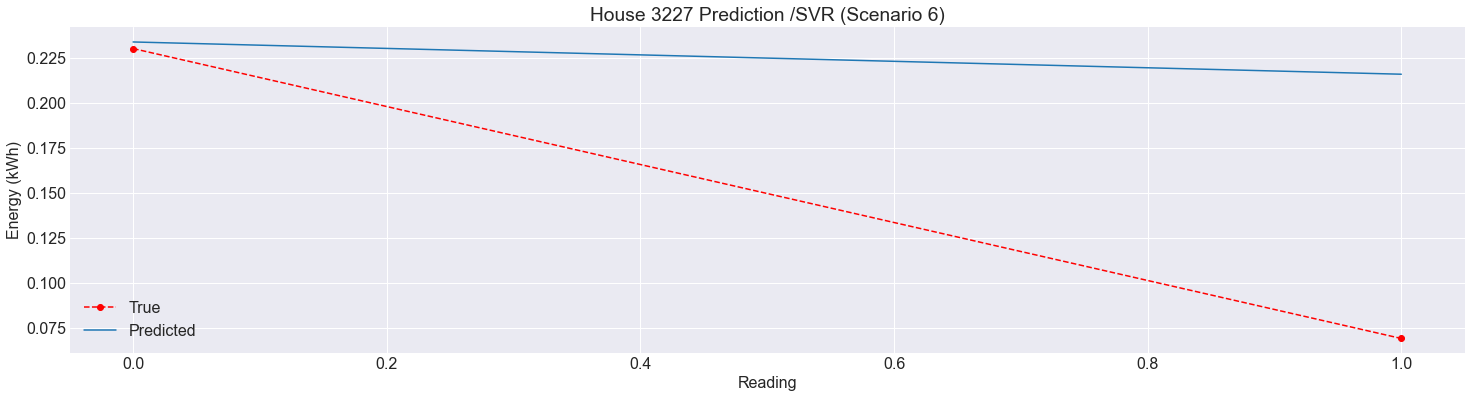

Mse:  0.066222998144623
Rmse: 0.257338295138175
Mae:  0.205631756129615
Mape:  131.100072453114223


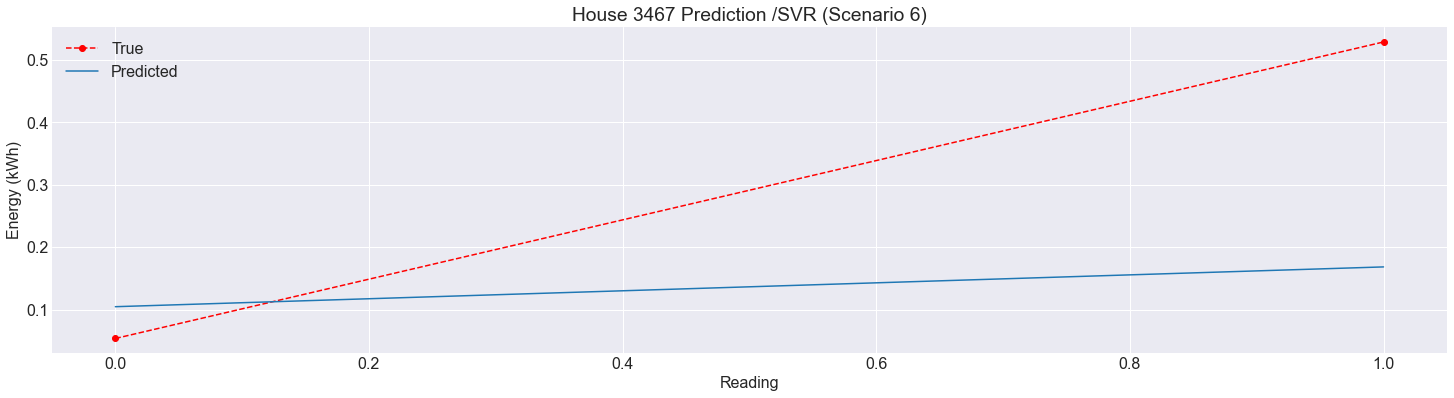

Mse:  0.032230188840218
Rmse: 0.179527682657070
Mae:  0.170408884959591
Mape:  59.468943337073533


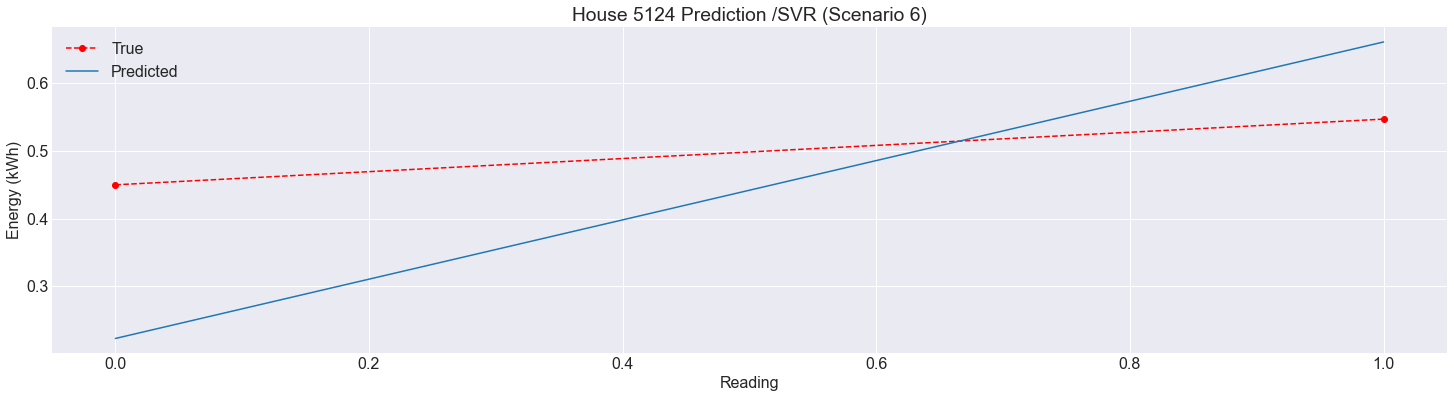

Mse:  0.000766131057942
Rmse: 0.027679072562895
Mae:  0.023750958449443
Mape:  7.261843294333478


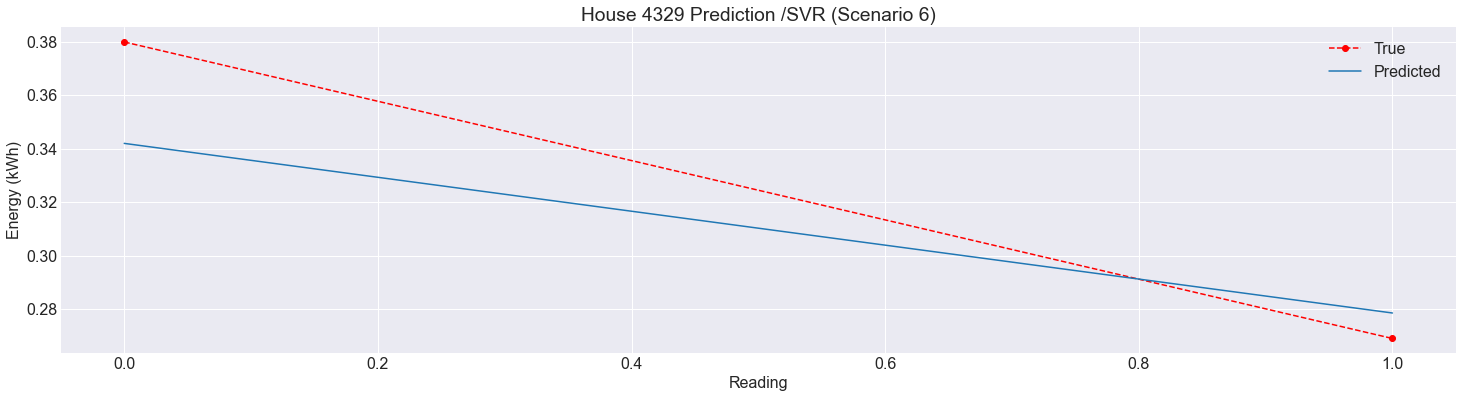

In [101]:
 ##### The households with an error have a '#' 
predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)


In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,0.001526,0.007458,0.078836,0.005640,0.000199,0.001591,0.109836,0.002608,0.013207,0.013249,...,0.005379,0.009397,0.005574,0.000071,0.017039,0.014222,0.010774,0.066223,0.032230,0.000766
RMSE_scores,0.039069,0.086357,0.280778,0.075101,0.014102,0.039881,0.331415,0.051067,0.114924,0.115105,...,0.073342,0.096938,0.074661,0.008403,0.130535,0.119257,0.103799,0.257338,0.179528,0.027679
MAE_scores,0.030009,0.084181,0.265550,0.054727,0.011964,0.039860,0.305461,0.050858,0.107661,0.103857,...,0.072721,0.096154,0.073097,0.008046,0.115725,0.099915,0.075203,0.205632,0.170409,0.023751
MAPE_scores,20.239768,514.681751,43.765028,42.355597,23.718532,39.188278,73.093719,44.054003,68.167731,46.419258,...,24.198529,63.233330,57.933397,9.259435,86.323762,29.083312,34.791916,131.100072,59.468943,7.261843


In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario2_1h_SVR.csv', index=False)